In [ ]:
# @title Import libraries and data
import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem  # for standard error of the mean
import pandas as pd
from scipy.stats import shapiro
import os
import scipy.stats as stats
import itertools
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import math
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from scipy.stats import skew
!pip install pingouin
import pingouin as pg
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imporation of Data and Useful functions

**df_clean :** Dataframe with no NaN Value and *OB Frequency not filtered*

**df_filt :** Dataframe with no NaN Value and *OB Frequency filtered*

**df_shock :** Filtered Dataframe with no NaN Value, *only Shock zone* and *OB Frequency filtered*

**df_safe :** Filtered Dataframe with no NaN Value, *only Safe zone* and *OB Frequency filtered*




In [ ]:
# @title Data Loading Code and pre-processing
'''
Import Data from file
'''
data= sc.loadmat ('/content/drive/MyDrive/Coding Projects/BME Paris/DeepLearning/Data_Model_30112023.mat')
#Connaitre les datas
print("Clés dans le fichier .mat :", data.keys())
# Voir numeros de souris qu il y a dans le fichier
data_structure = data['DATA']
Name = data["Name"][0]
mouse_ids = [key for key in data_structure.dtype.names if key.startswith('M')]
smo = 8


print("IDs des souris dans le fichier :", mouse_ids)

clean_name = []
for i in Name:
    clean_name+=[i[0]]


'''
Functions to Treat DATA
'''

def get_data(mouse_data_key,i):
    mouse_data = data_structure[mouse_data_key][0][0][:,i]
    return mouse_data

def remove_nans(lst):
    return [value for value in lst if not math.isnan(value)]

def max_consecutive_nans(lst):
    max_nans = 0
    current_nans = 0

    for value in lst:
        if math.isnan(value):  # Check if the value is NaN
            current_nans += 1
            max_nans = max(max_nans, current_nans)
        else:
            current_nans = 0  # Reset count when a non-NaN value is encountered

    return max_nans

def get_nan_positions(lst):
    return [index for index, value in enumerate(lst) if math.isnan(value)]

def runmean(L, smo=8,period=1):
    s = pd.Series(L).rolling(window=smo, center=True, min_periods=period).mean()
    return s

'''
Store DATA in a dictianory and taking the Data starting from the first shock
'''
clean_data = {}
for mouse_id in mouse_ids :
    clean_data[mouse_id] = {}
    k=sum(np.isnan(get_data(mouse_id,3))) #First NaN values of Time Since Last Shock because there were no shock before
    for i in range(len(Name)):
            clean_data[mouse_id][Name[i][0]] = get_data(mouse_id,i)[k:]



'''
Completting or removing nan Values in Position
'''

for mouse_id in mouse_ids:
    pos_nan= get_nan_positions(clean_data[mouse_id]['Position'])
    for pos in pos_nan:
        #print(f"{mouse_id} at {pos}")
        if pos+1 >= len(clean_data[mouse_id]['Global Time']) or pos-1 < 0:
            print(f"{mouse_id} at position {pos}")
        elif clean_data[mouse_id]['Global Time'][pos] - clean_data[mouse_id]['Global Time'][pos-1] == 2 :
            #print(f"1, {clean_data[mouse_id]['Position'][pos-1]}")
            clean_data[mouse_id]['Position'][pos] = clean_data[mouse_id]['Position'][pos-1]
        elif clean_data[mouse_id]['Global Time'][pos+1] - clean_data[mouse_id]['Global Time'][pos] == 2:
            #print(f"2, {clean_data[mouse_id]['Position'][pos+1]}")
            clean_data[mouse_id]['Position'][pos] = clean_data[mouse_id]['Position'][pos+1]
        else :
            print(f"{mouse_id} at position {pos}")
    pos_nan= get_nan_positions(clean_data[mouse_id]['Position'])
    for i in clean_data['M893'].keys():
        clean_data[mouse_id][i] = np.delete(clean_data[mouse_id][i],pos_nan)

'''
for mouse_id in mouse_ids:
    pos_nan= get_nan_positions(clean_data[mouse_id]['OB frequency'])
    for pos in pos_nan:
        #print(f"{mouse_id} at {pos}")
        if pos+1 >= len(clean_data[mouse_id]['Global Time']) or pos-1 < 0:
            print(f"{mouse_id} at position {pos}")
        elif clean_data[mouse_id]['Global Time'][pos] - clean_data[mouse_id]['Global Time'][pos-1] == 2 :
            #print(f"1, {clean_data[mouse_id]['Position'][pos-1]}")
            clean_data[mouse_id]['OB frequency'][pos] = clean_data[mouse_id]['OB frequency'][pos-1]
        elif clean_data[mouse_id]['Global Time'][pos+1] - clean_data[mouse_id]['Global Time'][pos] == 2:
            #print(f"2, {clean_data[mouse_id]['Position'][pos+1]}")
            clean_data[mouse_id]['OB frequency'][pos] = clean_data[mouse_id]['OB frequency'][pos+1]
        else :
            print(f"{mouse_id} at position {pos}")
    pos_nan= get_nan_positions(clean_data[mouse_id]['OB frequency'])
    for i in clean_data['M893'].keys():
        clean_data[mouse_id][i] = np.delete(clean_data[mouse_id][i],pos_nan)
'''

df_clean=pd.DataFrame(clean_data)

filt_data = clean_data.copy()

for mouse_id in mouse_ids:
    filt_data[mouse_id]['OB frequency'] = runmean(filt_data[mouse_id]['OB frequency'])

df_filt= pd.DataFrame(filt_data)

'''
Seperate Data
'''

def separate_zones(data,mouse_id):
    df = pd.DataFrame(dict(data[mouse_id]))
    # Séparer les données n fonction de la position linéaire lissée
    shock_zone_df = df[df['Position'] < 0.5].copy()
    safe_zone_df = df[df['Position'] >= 0.5].copy()

    # Detect rows that didn't classify into any zone
    classified_indices = shock_zone_df.index.union(safe_zone_df.index)

    # Detect rows that didn't classify into any zone
    unclassified_rows = df.loc[~df.index.isin(classified_indices)]

    print(f"Mouse {mouse_id}: Unclassified rows: {len(unclassified_rows)}")
    if len(unclassified_rows) > 0:
        print(unclassified_rows)
    return shock_zone_df, safe_zone_df


safe_fdata={}
shock_fdata={}
for mouse_id in mouse_ids:
    shock,safe = separate_zones(df_filt, mouse_id)
    shock_fdata[mouse_id] = dict(shock)
    safe_fdata[mouse_id] = dict(safe)

df_shock = pd.DataFrame(shock_fdata)
df_safe = pd.DataFrame(safe_fdata)

'''
Combine Data of all mouse
'''
# Créer une liste pour stocker les DataFrames individuels
all_mouse_data = []

# Parcourir chaque souris
for mouse_id in mouse_ids:
    # Récupérer les données pour cette souris
    # mouse_data = clean_data[mouse_id]

    # Créer un DataFrame pour cette souris
    mouse_df = pd.DataFrame(clean_data[mouse_id])

    # Ajouter une colonne pour l'ID de la souris
    mouse_df['Mouse ID'] = mouse_id

    # Ajouter ce DataFrame à la liste
    all_mouse_data.append(mouse_df)

# Concaténer tous les DataFrames en un seul
combined_df = pd.concat(all_mouse_data, ignore_index=True)

# Afficher un aperçu du DataFrame combiné

all_mouse_data = []

# Parcourir chaque souris
for mouse_id in mouse_ids:
    mouse_df = pd.DataFrame(dict(df_clean[mouse_id]))

    # Add a coloumn for id
    mouse_df['Mouse ID'] = mouse_id

    # Ajouter ce DataFrame à la liste
    all_mouse_data.append(mouse_df)

# Concaténer tous les DataFrames en un seul
combined_df_clean = pd.concat(all_mouse_data, ignore_index=True)

Clés dans le fichier .mat : dict_keys(['__header__', '__version__', '__globals__', 'DATA', 'Name'])
IDs des souris dans le fichier : ['M688', 'M739', 'M777', 'M849', 'M893', 'M1171', 'M1189']
M688 at position 264
M688 at position 462
M893 at position 368
M1189 at position 156
Mouse M688: Unclassified rows: 0
Mouse M739: Unclassified rows: 0
Mouse M777: Unclassified rows: 0
Mouse M849: Unclassified rows: 0
Mouse M893: Unclassified rows: 0
Mouse M1171: Unclassified rows: 0
Mouse M1189: Unclassified rows: 0


In [ ]:
# @title Useful Functions
'''
Axe limits
'''
axe_limits={}

for key in clean_name:
    X_all = clean_data['M688'][key]
    minX, maxX = np.nanmin(X_all),np.nanmax(X_all)
    for mouse_id in mouse_ids:
        X_all = clean_data[mouse_id][key]
        #print (f"X_all = {X_all}")
        minX = min(minX, np.nanmin(X_all))
        maxX = max(maxX, np.nanmax(X_all))
        axe_limits[key]=[minX,maxX]


def plot2d(df,mouse_data_key,x,y,smooth = [],filter1= runmean):
    X,Y = df[mouse_data_key][x], df[mouse_data_key][y]
    for i in smooth:
        if i == 0:
            X = filter1(X)
        elif i == 1:
            Y = filter1(Y)
    plt.plot(X,Y,label = f"Mouse {mouse_data_key}")
    plt.title(f"{x} vs {y} for {mouse_data_key}")
    plt.xlabel(f"{x}")
    plt.ylabel(f"{y}")
    plt.xlim ([axe_limits[x][0],axe_limits[x][1]])
    plt.ylim ([axe_limits[y][0],axe_limits[y][1]])


def subplot2d(df,mouse_data_key,x,y,ax,smooth = [],filter1= runmean,colorplot = 'blue'):
    X,Y = df[mouse_data_key][x], df[mouse_data_key][y]
    for i in smooth:
        if i == 0:
            X = filter1(X)
        elif i == 1:
            Y = filter1(Y)
    ax.scatter(X,Y,label = f"Mouse {mouse_data_key}", color = colorplot)
    ax.set_title(f"{x} vs {y} for {mouse_data_key}")
    ax.set_xlabel(f"{x}")
    ax.set_ylabel(f"{y}")
    ax.set_xlim (axe_limits[x][0],axe_limits[x][1])
    ax.set_ylim (axe_limits[y][0],axe_limits[y][1])
    ax.legend()


def subplot3d(df,mouse_data_key,x,y,z,ax3D,smooth = [],filter1= runmean):
    X,Y,Z = df[mouse_data_key][x], df[mouse_data_key][y], df[mouse_data_key][z]
    for i in smooth:
        if i == 0:
            X = filter1(X)
        elif i == 1:
            Y = filter1(Y)
        elif i == 2:
            Z = filter1(Z)
    scatter = ax3D.scatter(X, Y, Z, c=Z, cmap='viridis')
    ax3D.set_xlabel(f"{x}")
    ax3D.set_ylabel(f"{y}")
    ax3D.set_zlabel(f"{z}")
    ax3D.set_title(f'Mouse {mouse_data_key} - 3D Scatter')
    ax3D.set_xlim ([axe_limits[x][0],axe_limits[x][1]])
    ax3D.set_ylim ([axe_limits[y][0],axe_limits[y][1]])
    ax3D.set_zlim ([axe_limits[z][0],axe_limits[z][1]])
    fig.colorbar(scatter, ax=ax3D, shrink=0.5, aspect=5, label=f"{z}")

def normality(df,mouse_data_key,x) :
    data=df[mouse_data_key][x]
    stat_n, p_value_n = shapiro(data)
    # Interpret the p-value
    alpha_n = 0.05
    if p_value_n > alpha_n:
        normality=(x,True,p_value_n,stat_n)
    else:
        normality=(x,False,p_value_n,stat_n)
    return normality

def correlation(df,mouse_data_key,x,y):
    X = df[mouse_data_key][x]
    Y = df[mouse_data_key][y]
    if x == 0 :
        X = runmean(X)
    if y == 0 :
        Y = runmean(Y)
    if x==3 :
        X,Y= X[sum(np.isnan(X)):],Y[sum(np.isnan(X)):]
    if y==3:
        X,Y= X[sum(np.isnan(Y)):],Y[sum(np.isnan(Y)):]
    correlation_results = []
    if data_normality[mouse_data_key][x]['Normality'] == True and data_normality[mouse_data_key][y]['Normality'] == True:
        corr, p_value = stats.pearsonr(X, Y)
        test_type = 'Pearson'
        correlation_results = [corr,p_value,test_type]
    else :
        corr, p_value = stats.spearmanr(X, Y)
        test_type = 'Spearman'
        # Stocker les résultats
        correlation_results = [corr,p_value,test_type]
    return correlation_results



# Observation

## 3D plots

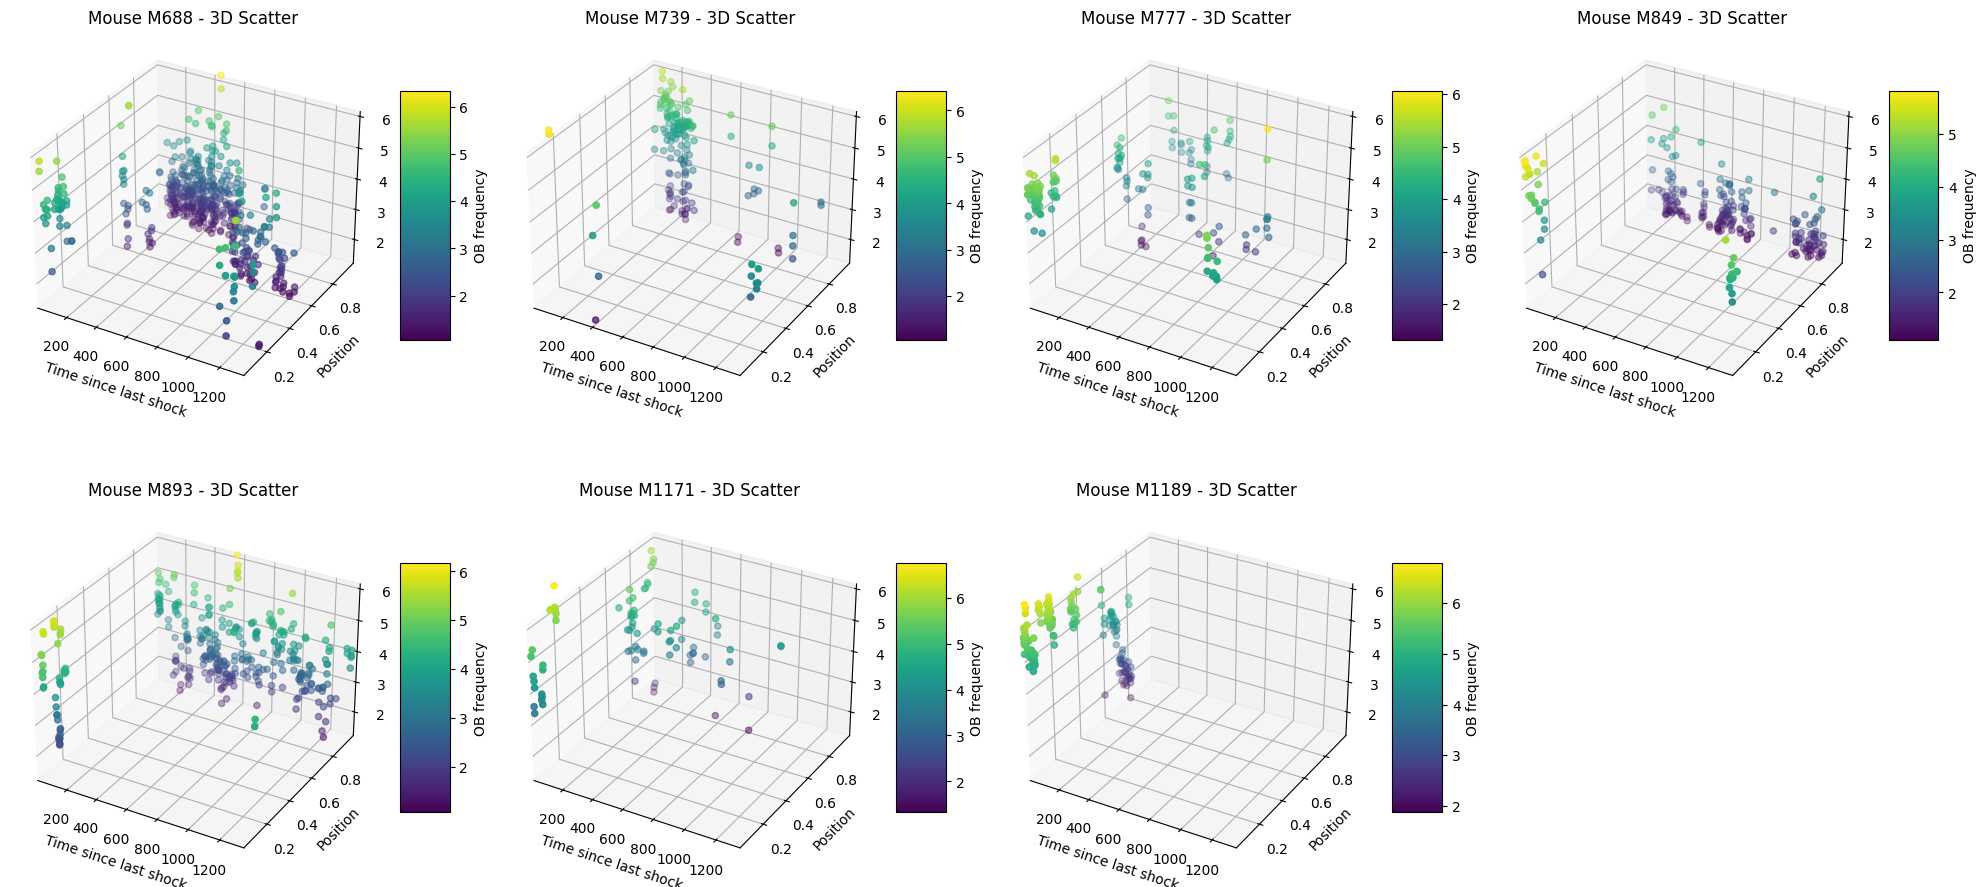

In [ ]:
# @title Figure 3: Time since last shock vs Position vs OB frequency

num_mice = len(mouse_ids)

fig = plt.figure(figsize=(20, 5 * int(num_mice/4)+5))

#Pour each souris
for i, mouse_id in enumerate(mouse_ids):
    ax3D = fig.add_subplot(int(num_mice/4)+1, 4, i+1,projection='3d')
    subplot3d(df_clean, mouse_id,"Time since last shock", "Position", "OB frequency",ax3D)

plt.tight_layout()
plt.show()



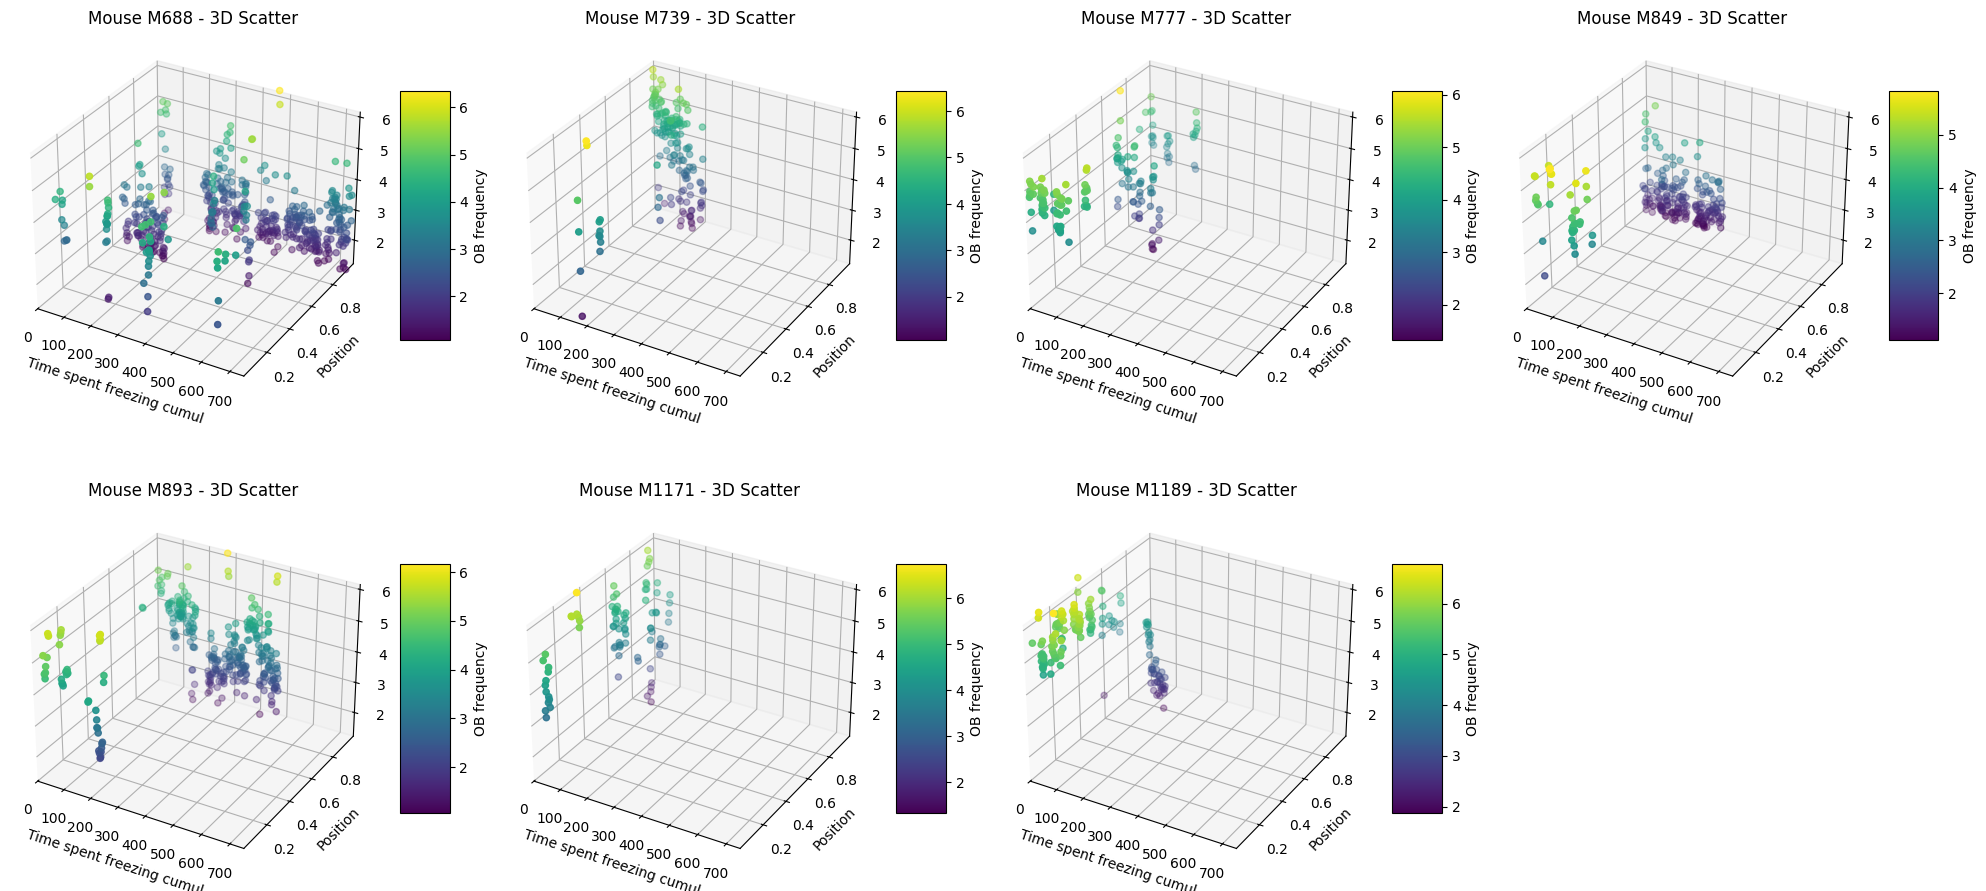

In [ ]:
# @title Figure 4: Time spent freezing cumul vs Position vs OB frequency

num_mice = len(mouse_ids)

fig = plt.figure(figsize=(20, 5 * int(num_mice/4)+5))

#Pour each souris
for i, mouse_id in enumerate(mouse_ids):
    ax3D = fig.add_subplot(int(num_mice/4)+1, 4, i+1,projection='3d')
    subplot3d(df_clean, mouse_id,"Time spent freezing cumul", "Position", "OB frequency",ax3D)

plt.tight_layout()
plt.show()


## 2D plot

Text(0.5, 1.0, 'OB Frequency vs Time spent freezing cumul for all mice')

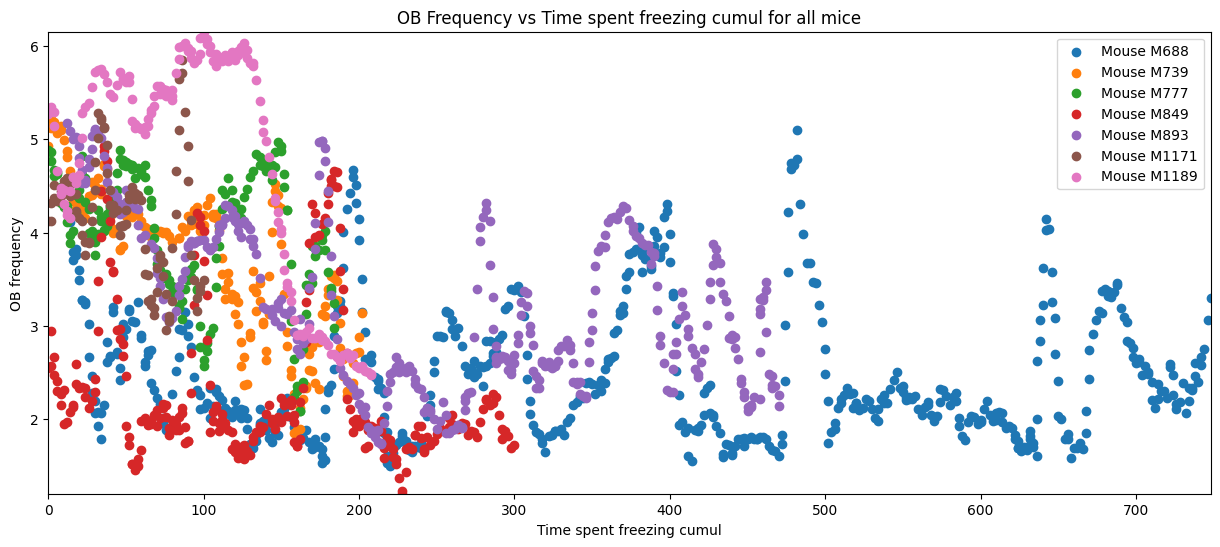

In [ ]:
# @title Figure 5: OB Frequency vs Time spent freezing cumul for all mice
cmap = plt.get_cmap('tab10')
num_colors = cmap.N  # Number of colors in the colormap
colors = [cmap(i)[:3] for i in range(num_colors)]  # Extract RGB values

fig, axs = plt.subplots(figsize=(15, 6))
for i in range(len(mouse_ids)):
    subplot2d(df_filt, mouse_ids[i], 'Time spent freezing cumul','OB frequency',axs,colorplot=colors[i])
axs.set_title(f"OB Frequency vs Time spent freezing cumul for all mice")

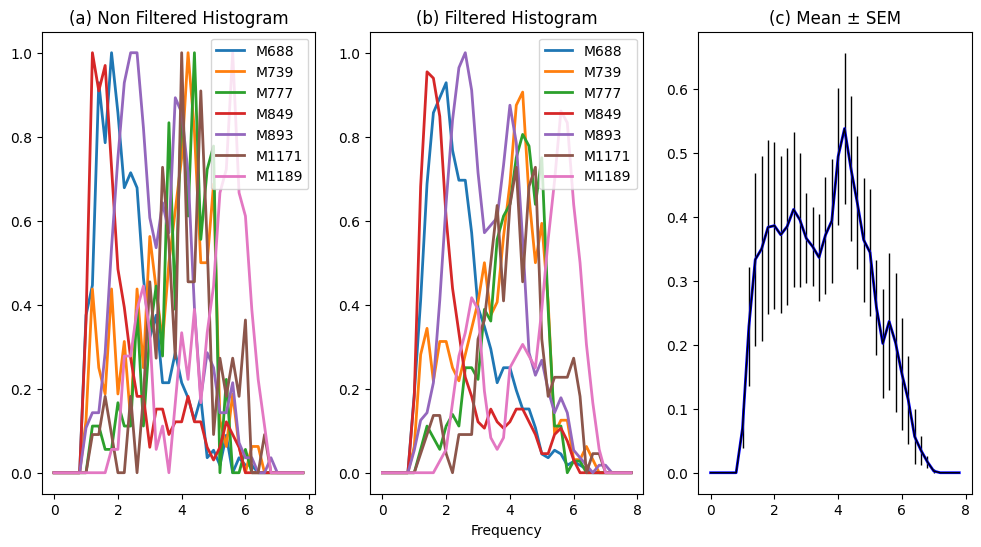

In [ ]:
# @title Figure 6: Distribution of time since last shock
histograms = []
bin_centers = np.arange(0, 8.2, 0.2)

# Create histogram for the first column, normalize
for mouse_id in mouse_ids:
    counts, _ = np.histogram(get_data(mouse_id,0), bins=bin_centers)
    histograms.append(counts)

runmean_histograms = [pd.Series(hist / hist.max()).rolling(window=2, center=True, min_periods=1).mean() for hist in histograms]
histogram_no_filter = [hist / hist.max() for hist in histograms]
mean_hist = np.mean(runmean_histograms, axis=0)
error = sem(runmean_histograms, axis=0)

# Combined figure for all mice
fig_combined, axs_combined = plt.subplots(1, 3, figsize=(12, 6))

# Plot all individual histograms in the first combined subplot
for i,hist in enumerate(runmean_histograms):
    axs_combined[1].plot(bin_centers[:-1], hist, linewidth=2, label =f"{mouse_ids[i]}")
    axs_combined[1].set_title('(b) Filtered Histogram')
    axs_combined[1].legend(loc='upper right')
    axs_combined[1].set_xlabel('Frequency')


for i,hist in enumerate (histogram_no_filter):
    axs_combined[0].plot(bin_centers[:-1], hist, linewidth=2,label =f"{mouse_ids[i]}")
    axs_combined[0].set_title('(a) Non Filtered Histogram')
    axs_combined[0].legend(loc='upper right')

# Plot mean with error bars in the second combined subplot
axs_combined[2].errorbar(bin_centers[:-1], mean_hist, yerr=error, color='k', linewidth=1)
axs_combined[2].plot(bin_centers[:-1], mean_hist, color='b', linewidth=2)
axs_combined[2].set_title('(c) Mean ± SEM')

plt.show()

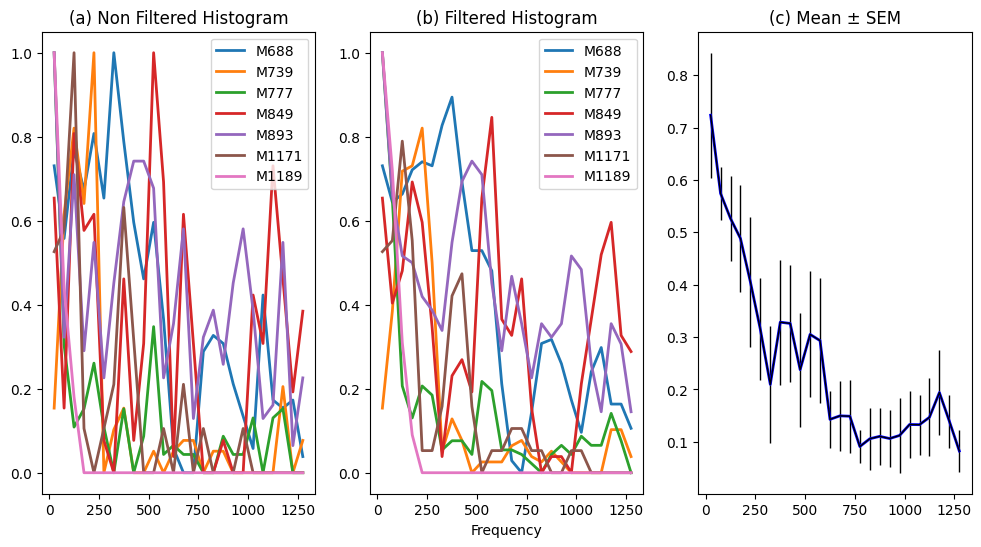

In [ ]:
# @title Figure 16 (A): Distribution Time since last shock
histograms = []
bin_edges = np.arange(0, 1351, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute actual bin centers


# Create histogram for the first column, normalize
for mouse_id in mouse_ids:
    #print (mouse_id)
    counts, _ = np.histogram(get_data(mouse_id,3), bins=bin_centers)
    #print (counts)
    histograms.append(counts)

runmean_histograms = [pd.Series(hist / hist.max()).rolling(window=2, center=True, min_periods=1).mean() for hist in histograms]
histogram_no_filter = [hist / hist.max() for hist in histograms]
mean_hist = np.mean(runmean_histograms, axis=0)
error = sem(runmean_histograms, axis=0)

# Combined figure for all mice
fig_combined, axs_combined = plt.subplots(1, 3, figsize=(12, 6))

# Plot all individual histograms in the first combined subplot
for i,hist in enumerate(runmean_histograms):
    axs_combined[1].plot(bin_centers[:-1], hist, linewidth=2, label =f"{mouse_ids[i]}")
    axs_combined[1].set_title('(b) Filtered Histogram')
    axs_combined[1].legend(loc='upper right')
    axs_combined[1].set_xlabel('Frequency')


for i,hist in enumerate (histogram_no_filter):
    axs_combined[0].plot(bin_centers[:-1], hist, linewidth=2,label =f"{mouse_ids[i]}")
    axs_combined[0].set_title('(a) Non Filtered Histogram')
    axs_combined[0].legend(loc='upper right')

# Plot mean with error bars in the second combined subplot
axs_combined[2].errorbar(bin_centers[:-1], mean_hist, yerr=error, color='k', linewidth=1)
axs_combined[2].plot(bin_centers[:-1], mean_hist, color='b', linewidth=2)
axs_combined[2].set_title('(c) Mean ± SEM')

plt.show()

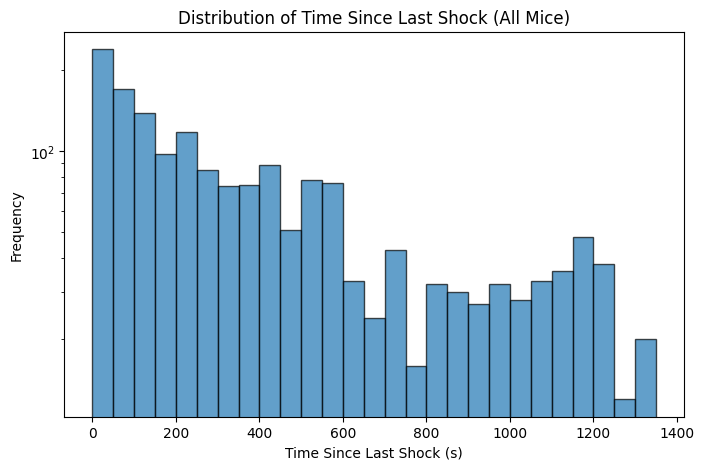

In [ ]:
# Collect all data into one list
all_data = []
for mouse_id in mouse_ids:
    data = get_data(mouse_id, 3)  # Assuming column index 3 is "Time since last shock"
    all_data.extend(data)  # Flatten the data into one list

# Define bins: Adjust the step size for better granularity
bins = np.arange(0, 1351, 50)  # Bins every 50 seconds

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_data, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("Time Since Last Shock (s)")
plt.ylabel("Frequency")
plt.title("Distribution of Time Since Last Shock (All Mice)")
plt.yscale("log")  # If data is highly skewed, log scale might help visualize

plt.show()


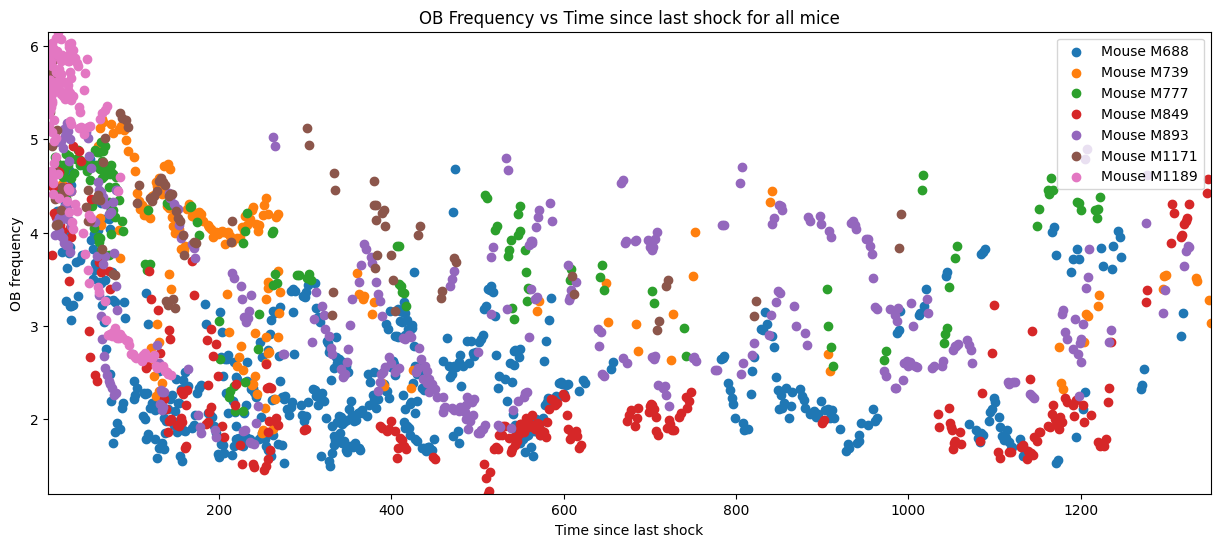

In [ ]:
# @title Figure 16 (B): OB frequency depending on Time since last shock
cmap = plt.get_cmap('tab10')
num_colors = cmap.N  # Number of colors in the colormap
colors = [cmap(i)[:3] for i in range(num_colors)]  # Extract RGB values

fig, axs = plt.subplots(figsize=(15, 6))
for i in range(len(mouse_ids)):
    subplot2d(df_filt, mouse_ids[i], 'Time since last shock','OB frequency',axs,colorplot=colors[i])
axs.set_title(f"OB Frequency vs Time since last shock for all mice")
axs.legend(loc = 'upper right')

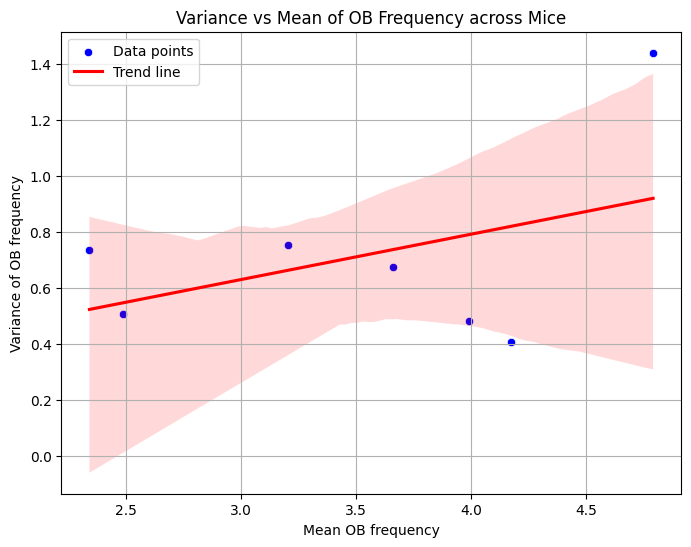

In [ ]:
#  @title Figure 13: Variance depending on mean

mean_var_data = combined_df.groupby("Mouse ID")["OB frequency"].agg(['mean', 'var']).reset_index()

# Plot variance vs mean
plt.figure(figsize=(8, 6))
sns.scatterplot(x=mean_var_data["mean"], y=mean_var_data["var"], color="b", label="Data points")

# Optionally, fit a trend line
sns.regplot(x=mean_var_data["mean"], y=mean_var_data["var"], scatter=False, color="r", label="Trend line")

# Labels and title
plt.xlabel("Mean OB frequency")
plt.ylabel("Variance of OB frequency")
plt.title("Variance vs Mean of OB Frequency across Mice")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Safe vs shock

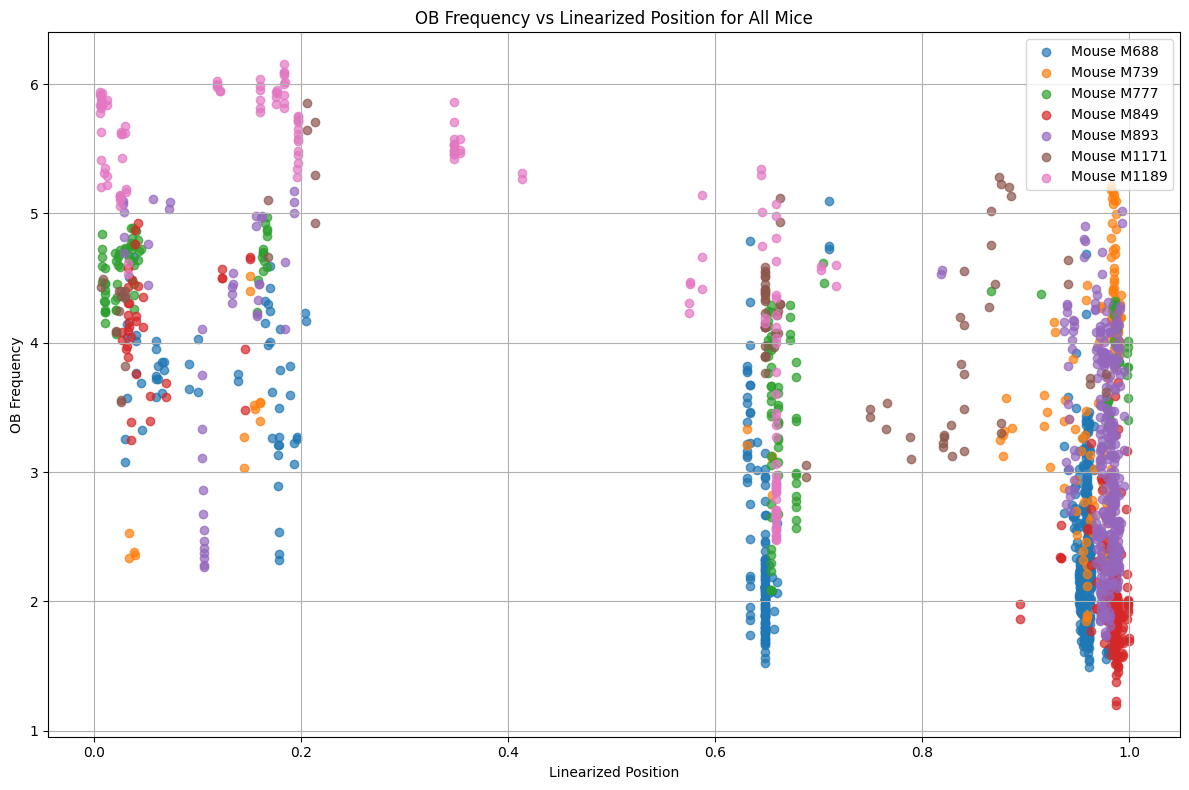

In [ ]:
# @title Figure 7: OB frequency as a function of linearized position for all mice
plt.figure(figsize=(12, 8))

# Loop through all mice
for mouse_id in mouse_ids:
    # Extract data for the current mouse
    mouse_data = mouse_data =combined_df[ combined_df ['Mouse ID']==mouse_id ]
    ob_frequency = mouse_data['OB frequency']  # OB Frequency
    linear_position = mouse_data['Position']  # Linear Position

    # Optionally smooth linear position
    linear_position_smoothed = pd.Series(linear_position).rolling(window=1, center=True, min_periods=1).mean()

    # Plot OB Frequency vs Linearized Position for the mouse
    plt.scatter(linear_position_smoothed, ob_frequency, label=f'Mouse {mouse_id}', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Linearized Position')
plt.ylabel('OB Frequency')
plt.title('OB Frequency vs Linearized Position for All Mice')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

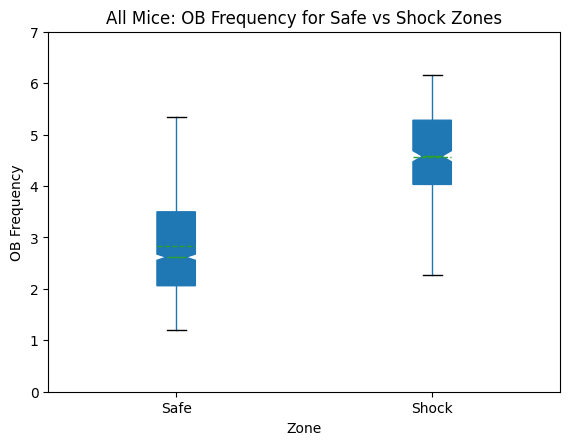

In [ ]:
# @title Figure 8: All mice per zone - Boxplot

combined_data = []

for mouse_id in mouse_ids:
    OB_safe_all = df_safe[mouse_id]['OB frequency']
    OB_shock_all = df_shock[mouse_id]['OB frequency']

    # Add safe and shock data to combined list with zone labels
    combined_data.extend([(freq, 'Safe') for freq in OB_safe_all])
    combined_data.extend([(freq, 'Shock') for freq in OB_shock_all])

# Convert combined data into a DataFrame
combined_df_zones_ob = pd.DataFrame(combined_data, columns=['OB Frequency', 'Zone'])

# Boxplot for all mice combined
plt.figure(figsize=(8, 6))
combined_df_zones_ob.boxplot(column='OB Frequency', by='Zone', vert=True, patch_artist=True,
                  meanline=True, showmeans=True, notch=True)
plt.title('All Mice: OB Frequency for Safe vs Shock Zones')
plt.suptitle('')
plt.ylabel('OB Frequency')
plt.ylim([0, 7])
plt.xlabel('Zone')
plt.grid()
plt.show()

In [ ]:
#@title Figure 8: All mice per zone - Statistics

import scipy.stats as stats
#from statsmodels.stats.weightstats import ztest

# Flatten
OB_shock_all_flat = OB_shock_all.values.flatten()
OB_safe_all_flat = OB_safe_all.values.flatten()


# Print means and standard deviations
print(f"Mean shock zone: {np.mean(OB_shock_all_flat):.2f}")
print(f"Mean safe zone: {np.mean(OB_safe_all_flat):.2f}")
print(f"Standard deviation shock zone: {np.std(OB_shock_all_flat):.2f}")
print(f"Standard deviation safe zone: {np.std(OB_safe_all_flat):.2f}")

# Use Z-test for large sample sizes
method = "Z-test"
print(f"Method: {method}")

# Perform the Z-test
stat, p_value = ztest(OB_shock_all_flat, OB_safe_all_flat)

# Print results
print(f"{method} Test Results: Statistic = {stat:.4f}, p-value = {p_value:.4e}")

# Interpretation
if p_value < 0.05:
    print("We reject H0: Means are statistically different.")
else:
    print("We cannot reject H0: Means are not statistically different.")


Mean shock zone: 5.64
Mean safe zone: 3.58
Standard deviation shock zone: 0.32
Standard deviation safe zone: 0.91
Method: Z-test
Z-test Test Results: Statistic = 19.8425, p-value = 1.2783e-87
We reject H0: Means are statistically different.


## All mice separated by zone

<ipython-input-15-d202cee40a59>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot_safe, labels= mouse_ids, patch_artist=True, notch =True, showmeans= True, meanline=True)


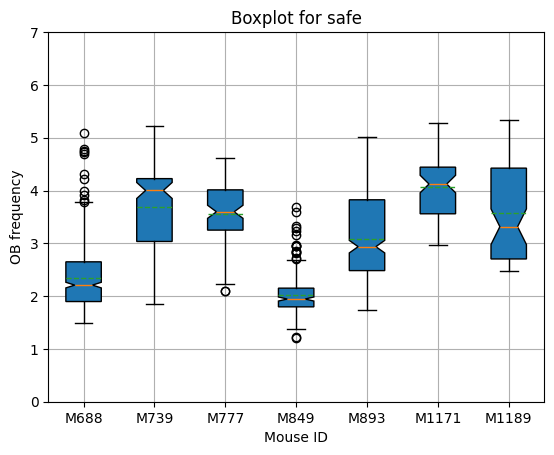

<ipython-input-15-d202cee40a59>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot_shock, labels= mouse_ids, patch_artist=True, notch =True, showmeans= True, meanline=True)


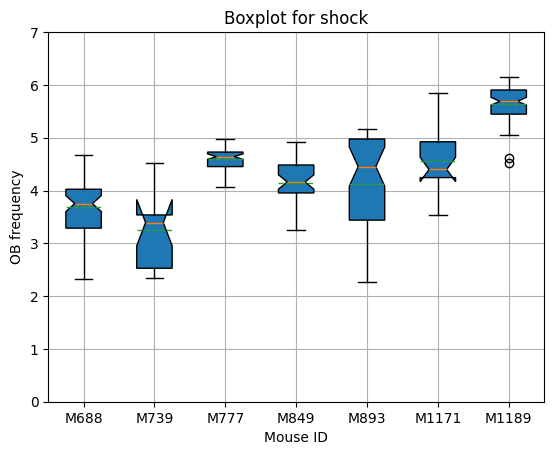

In [ ]:
# @title All mice separated per zone - Boxplot per zone

data_boxplot_safe=[]
data_boxplot_shock=[]
for mouse_id in mouse_ids:
  data_boxplot_safe.append(df_safe[mouse_id]['OB frequency'])
  data_boxplot_shock.append(df_shock[mouse_id]['OB frequency'])


plt.boxplot(data_boxplot_safe, labels= mouse_ids, patch_artist=True, notch =True, showmeans= True, meanline=True)
plt.title(f'Boxplot for safe')
plt.ylabel('OB frequency')
plt.ylim([0,7])
plt.xlabel('Mouse ID')
plt.grid()
plt.show()


plt.title(f'Boxplot for shock')
plt.ylabel('OB frequency')
plt.ylim([0,7])
plt.xlabel('Mouse ID')
plt.boxplot(data_boxplot_shock, labels= mouse_ids, patch_artist=True, notch =True, showmeans= True, meanline=True)
plt.grid()
plt.show()


In [ ]:
# @title All mice separted per zone - Proportion of safe/ shock in the overall population

total_data_all= []
for mouse_id in mouse_ids:
    total_data_all.append(df_filt[mouse_id]['OB frequency'])

print (len(data_boxplot_safe[0]))
print (len(data_boxplot_shock[0]))


# Calculate the proportion of safe data
safe_proportion = len(data_boxplot_safe[0]) / len(total_data_all[0])
print(f"Proportion of safe zone: {safe_proportion:.2%}")
# Calculate the proportion of shock data
shock_proportion = len(data_boxplot_shock[0]) / len(total_data_all[0])
print(f"Proportion of shock zone: {shock_proportion:.2%} \n")

488
58
Proportion of safe zone: 89.38%
Proportion of shock zone: 10.62% 



In [ ]:
# @title Figure 9/Annex 1: Statistic per zone

# --- Collect pairwise comparisons ---
p_values_safe = []
p_values_shock = []

mouse_pairs = list(itertools.combinations(mouse_ids, 2))  # Ensure unique comparisons

for mouse_id1, mouse_id2 in mouse_pairs:
    # --- Safe Zone Analysis ---
    ob_data_mouse1_safe = df_safe[mouse_id1]['OB frequency']
    ob_data_mouse2_safe = df_safe[mouse_id2]['OB frequency']

    # Check normality for safe zone
    if normality(df_safe, mouse_id1, 'OB frequency')[1] and normality(df_safe, mouse_id2, 'OB frequency')[1]:
        if len(ob_data_mouse1_safe) >= 30 and len(ob_data_mouse2_safe) >= 30:
            _, p_safe = sm.stats.ztest(ob_data_mouse1_safe, ob_data_mouse2_safe)
        else:
            _, p_safe = ttest_ind(ob_data_mouse1_safe, ob_data_mouse2_safe)
    else:
        _, p_safe = ranksums(ob_data_mouse1_safe, ob_data_mouse2_safe)

    p_values_safe.append(p_safe)

    # --- Shock Zone Analysis ---
    ob_data_mouse1_shock = df_shock[mouse_id1]['OB frequency']
    ob_data_mouse2_shock = df_shock[mouse_id2]['OB frequency']

    # Check normality for shock zone
    if normality(df_shock, mouse_id1, 'OB frequency')[1] and normality(df_shock, mouse_id2, 'OB frequency')[1]:
        if len(ob_data_mouse1_shock) >= 30 and len(ob_data_mouse2_shock) >= 30:
            _, p_shock = sm.stats.ztest(ob_data_mouse1_shock, ob_data_mouse2_shock)
        else:
            _, p_shock = ttest_ind(ob_data_mouse1_shock, ob_data_mouse2_shock)
    else:
        _, p_shock = ranksums(ob_data_mouse1_shock, ob_data_mouse2_shock)

    p_values_shock.append(p_shock)

# --- Multiple Testing Correction ---
rejected_safe, corrected_p_values_safe, _, _ = multipletests(p_values_safe, method='hs')
rejected_shock, corrected_p_values_shock, _, _ = multipletests(p_values_shock, method='hs')

# Print Results
print("=== Corrected p-values (Safe Zone) ===")
print(corrected_p_values_safe)
print (rejected_safe)
print (p_values_safe)

print("\n=== Corrected p-values (Shock Zone) ===")
print(corrected_p_values_shock)
print (rejected_shock)
print (p_values_shock)

=== Corrected p-values (Safe Zone) ===
[7.84504530e-49 3.78594681e-36 2.39071013e-12 3.27923545e-40
 4.47344835e-36 2.31373399e-22 1.46238379e-01 1.55145531e-49
 1.02520713e-12 1.02520233e-02 7.56639666e-01 1.86227915e-38
 3.28726343e-07 2.36137759e-05 8.66668708e-01 2.76841637e-53
 3.30091338e-34 2.69041407e-28 3.14769437e-17 2.92066777e-04
 7.11014959e-03]
[ True  True  True  True  True  True False  True  True  True False  True
  True  True False  True  True  True  True  True  True]
[4.1289712100440173e-50, 2.3662167576543e-37, 2.656344590355428e-13, 1.8217974727021005e-41, 2.9822988973765583e-37, 1.9281116571051552e-23, 0.05133646047937679, 7.757276570706342e-51, 1.0252071255512788e-13, 0.002572918664535141, 0.5066843465093659, 1.0954583243501993e-39, 4.1090798740536576e-08, 3.3734306983603726e-06, 0.8666687081063709, 1.318293511032984e-54, 2.3577952725137242e-35, 2.0695492852670756e-29, 2.8615403330720335e-18, 4.868372110526598e-05, 0.001426091595759406]

=== Corrected p-values (Sh

<ipython-input-18-03f7e2a6f4e0>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot_safe_reorganised, labels= mouse_ids_reorganised, patch_artist=True, notch =True, showmeans= True, meanline=True)


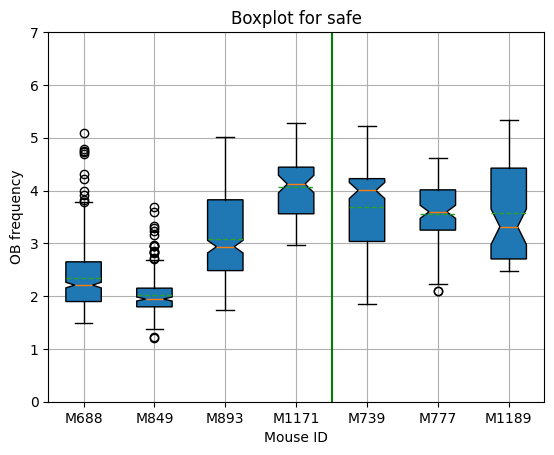

In [ ]:
# @title Figure 9: Safe boxplot revisited

data_boxplot_safe_reorganised=[]
#print (mouse_ids)
mouse_ids_reorganised= ['M688', 'M849', 'M893', 'M1171',  'M739', 'M777','M1189']
#print (df_safe[mouse_ids_reorganised])
#print (df_safe[mouse_ids_reorganised][mouse_id]['OB frequency'])
for mouse_id in mouse_ids_reorganised:
  data_boxplot_safe_reorganised.append(df_safe[mouse_ids_reorganised][mouse_id]['OB frequency'])
#print (data_boxplot_safe_reorganised)


plt.boxplot(data_boxplot_safe_reorganised, labels= mouse_ids_reorganised, patch_artist=True, notch =True, showmeans= True, meanline=True)
plt.title(f'Boxplot for safe')
plt.ylabel('OB frequency')
plt.ylim([0,7])
plt.xlabel('Mouse ID')
plt.axvline(4.5, c='g')
plt.grid()
plt.show()



<ipython-input-19-662fbf3c32ed>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot_shock_reorganised, labels= mouse_ids_reorganised_shock, patch_artist=True, notch =True, showmeans= True, meanline=True)


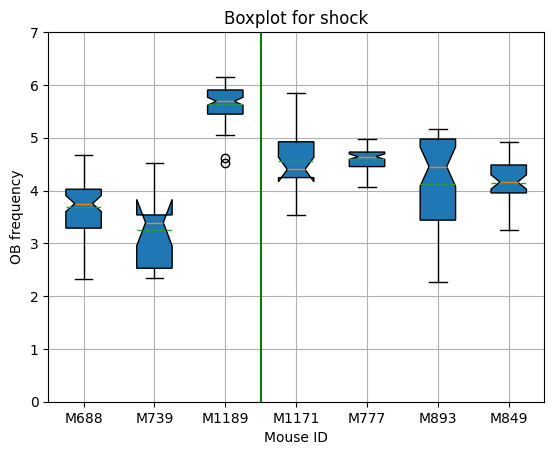

In [ ]:
# @title Figure 9: Shock boxplot revisited

data_boxplot_shock_reorganised=[]
#print (mouse_ids)
mouse_ids_reorganised_shock= ['M688',  'M739', 'M1189', 'M1171','M777', 'M893', 'M849']

for mouse_id in mouse_ids_reorganised_shock:
  #print (mouse_id)
  #print (df_shock[mouse_ids_reorganised_shock][mouse_id]['OB frequency'])
  data_boxplot_shock_reorganised.append(df_shock[mouse_ids_reorganised_shock][mouse_id]['OB frequency'])
#print (data_boxplot_safe_reorganised)


plt.boxplot(data_boxplot_shock_reorganised, labels= mouse_ids_reorganised_shock, patch_artist=True, notch =True, showmeans= True, meanline=True)
plt.title(f'Boxplot for shock')
plt.ylabel('OB frequency')
plt.ylim([0,7])
plt.xlabel('Mouse ID')
plt.axvline(3.5, c='g')
plt.grid()
plt.show()



In [ ]:
# @title Statistics compare mice 2 by 2 for each zone

import scipy.stats as stats
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
from scipy.stats import fisher_exact
from scipy.stats import shapiro
from scipy.stats import levene

#Post hoc 2 samples at time
mouse_ids1 = mouse_ids.copy()
for mouse_id in mouse_ids:
    mouse_ids1.remove(mouse_id)
    for mouse_id1 in mouse_ids1:
        #print(mouse_id1,mouse_ids1)
        if mouse_id1 != mouse_id:
            print(f"For mouse pair ({mouse_id} vs {mouse_id1}):")
            print("SHOCK ZONE")
             # Récupérer les fréquences OB pour chaque souris dans la zone "Shock"
            ob_data_mouse1 = df_shock[mouse_id]['OB frequency']
            ob_data_mouse2 = df_shock[mouse_id1]['OB frequency']


            # Length
            ## Bigger than 30 ==> ztest
            if len(ob_data_mouse1) >= 30 and len(ob_data_mouse2) >= 30:
                print ("Samples bigger than 30")
                print ( len ( ob_data_mouse1))
                print ( len ( ob_data_mouse2))
                # Use z-test for large sample sizes
                method = 'Z-test'
                print(f"Method: {method}")
                stat, p_value = sm.stats.ztest(ob_data_mouse1, ob_data_mouse2)


            ## Samples smaller than 30
            else :
                print ("Samples smaller than 30")
                print ( len ( ob_data_mouse1))
                print ( len ( ob_data_mouse2))

              # Normality testing : Shapiro - Wilk
                method = 'shapiro-wilk'
                stat1_shapi, p_value1_shapi = shapiro (ob_data_mouse1)
                stat2_shapi, p_value2_shapi = shapiro (ob_data_mouse2)

                ## No normal distribution
                if p_value1_shapi < 0.05 or p_value2_shapi < 0.05:
                    print ("No normal distribution")
                    #Wilcoxon's test
                    method = 'Wilcoxon Rank sum'
                    #print (method)
                    # Effectuer le test de Wilcoxon pour les deux échantillons
                    stat, p_value = ranksums(ob_data_mouse1, ob_data_mouse2,
                                alternative='two-sided', nan_policy='omit')



                # Normal distribution proven
                else:
                    print ("Normal distribution")
                    #print("Normal distribution detected. Proceeding with parametric tests.")
                    # Test for equal variances
                    #print("Testing for equal variances (Levene's test)")
                    stat_var, p_value_var = levene(ob_data_mouse1, ob_data_mouse2)

                    if p_value_var < 0.05:
                      print("Unequal variances detected. Using Welch's t-test.")
                      method = "Welch's t-test"
                      stat, p_value = ttest_ind(ob_data_mouse1, ob_data_mouse2, equal_var=False)
                    else:
                        print("Equal variances detected. Using standard t-test.")
                        method = "t-test"
                        stat, p_value = ttest_ind(ob_data_mouse1, ob_data_mouse2, equal_var=True)


            # Print
            print(f"For mouse pair ({mouse_id} vs {mouse_id1}):")
            print(f"{method} Test Results: Statistic = {stat}, p-value = {p_value}")

            # Interpreting
            if p_value < 0.05:
                  print("We reject H0: Means are statistically different.\n")
            else:
                  print("We cannot reject H0: Means are not statistically different.\n")



            print("SAFE ZONE")
             # Récupérer les fréquences OB pour chaque souris dans la zone "Safe"
            ob_data_mouse1 = df_safe[mouse_id]['OB frequency']
            ob_data_mouse2 = df_safe[mouse_id1]['OB frequency']


            # Length
            ## Bigger than 30 ==> ztest
            if len(ob_data_mouse1) >= 30 and len(ob_data_mouse2) >= 30:
                print ("Samples bigger than 30")
                print ( len ( ob_data_mouse1))
                print ( len ( ob_data_mouse2))
                # Use z-test for large sample sizes
                method = 'Z-test'
                print(f"Method: {method}")
                stat, p_value = sm.stats.ztest(ob_data_mouse1, ob_data_mouse2)


            ## Samples smaller than 30
            else :
                print ("Samples smaller than 30")
                print ( len ( ob_data_mouse1))
                print ( len ( ob_data_mouse2))

              # Normality testing : Shapiro - Wilk
                method = 'shapiro-wilk'
                stat1_shapi, p_value1_shapi = shapiro (ob_data_mouse1)
                stat2_shapi, p_value2_shapi = shapiro (ob_data_mouse2)

                ## No normal distribution
                if p_value1_shapi < 0.05 or p_value2_shapi < 0.05:
                    print ("No normal distribution")
                    #Wilcoxon's test
                    method = 'Wilcoxon Rank sum'
                    #print (method)
                    # Effectuer le test de Wilcoxon pour les deux échantillons
                    stat, p_value = ranksums(ob_data_mouse1, ob_data_mouse2,
                                alternative='two-sided', nan_policy='omit')



                # Normal distribution proven
                else:
                    print ("Normal distribution")
                    #print("Normal distribution detected. Proceeding with parametric tests.")
                    # Test for equal variances
                    #print("Testing for equal variances (Levene's test)")
                    stat_var, p_value_var = levene(ob_data_mouse1, ob_data_mouse2)

                    if p_value_var < 0.05:
                      print("Unequal variances detected. Using Welch's t-test.")
                      method = "Welch's t-test"
                      stat, p_value = ttest_ind(ob_data_mouse1, ob_data_mouse2, equal_var=False)
                    else:
                        print("Equal variances detected. Using standard t-test.")
                        method = "t-test"
                        stat, p_value = ttest_ind(ob_data_mouse1, ob_data_mouse2, equal_var=True)


            # Print
            print(f"For mouse pair ({mouse_id} vs {mouse_id1}):")
            print(f"{method} Test Results: Statistic = {stat}, p-value = {p_value}")

            # Interpreting
            if p_value < 0.05:
                  print("We reject H0: Means are statistically different.\n")
            else:
                  print("We cannot reject H0: Means are not statistically different.\n")





For mouse pair (M688 vs M739):
SHOCK ZONE
Samples smaller than 30
58
13
Normal distribution
Equal variances detected. Using standard t-test.
For mouse pair (M688 vs M739):
t-test Test Results: Statistic = 2.6113135376035923, p-value = 0.011057145627690923
We reject H0: Means are statistically different.

SAFE ZONE
Samples bigger than 30
488
152
Method: Z-test
For mouse pair (M688 vs M739):
Z-test Test Results: Statistic = -22.37116586554975, p-value = 7.514704829770452e-111
We reject H0: Means are statistically different.

For mouse pair (M688 vs M777):
SHOCK ZONE
Samples bigger than 30
58
67
Method: Z-test
For mouse pair (M688 vs M777):
Z-test Test Results: Statistic = -13.184104641916024, p-value = 1.0833251886885312e-39
We reject H0: Means are statistically different.

SAFE ZONE
Samples bigger than 30
488
93
Method: Z-test
For mouse pair (M688 vs M777):
Z-test Test Results: Statistic = -18.28619342857803, p-value = 1.0660450944834433e-74
We reject H0: Means are statistically differe

Mouse M688:
Proportion of safe zone: 89.38%


<ipython-input-21-1f32a8bdc82c>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)


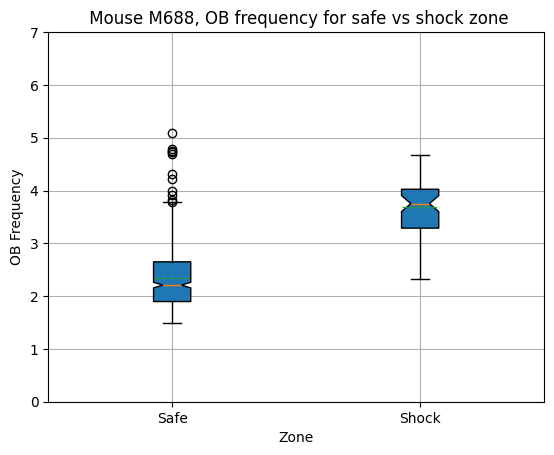

Mouse M739:
Proportion of safe zone: 89.38%


<ipython-input-21-1f32a8bdc82c>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)


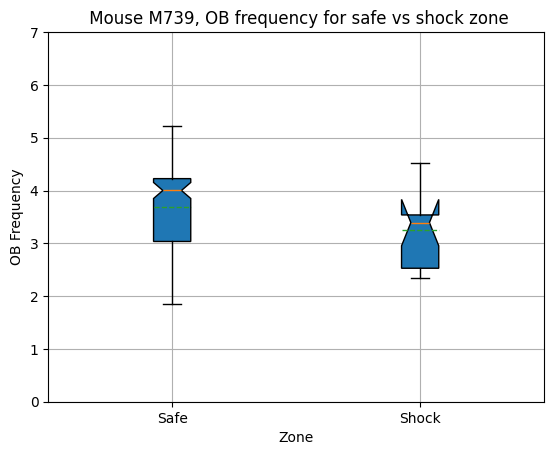

Mouse M777:
Proportion of safe zone: 89.38%


<ipython-input-21-1f32a8bdc82c>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)


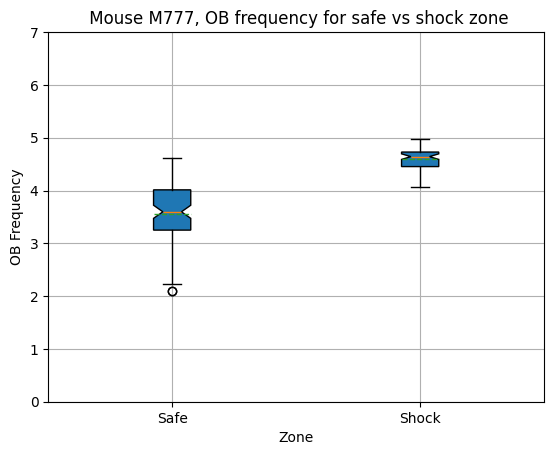

Mouse M849:
Proportion of safe zone: 89.38%


<ipython-input-21-1f32a8bdc82c>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)


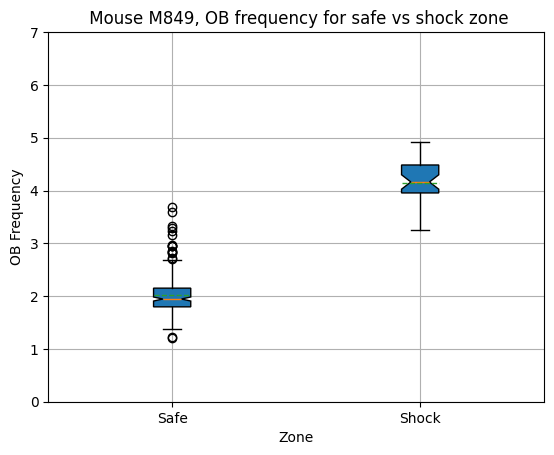

Mouse M893:
Proportion of safe zone: 89.38%


<ipython-input-21-1f32a8bdc82c>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)


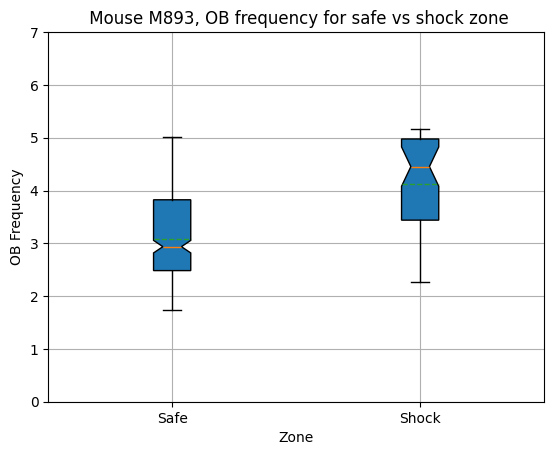

Mouse M1171:
Proportion of safe zone: 89.38%


<ipython-input-21-1f32a8bdc82c>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)


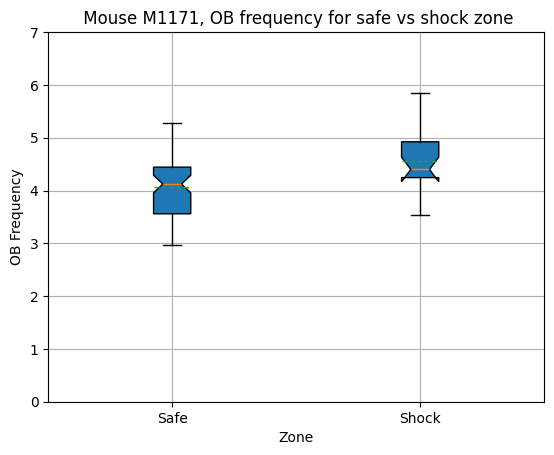

Mouse M1189:
Proportion of safe zone: 89.38%


<ipython-input-21-1f32a8bdc82c>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)


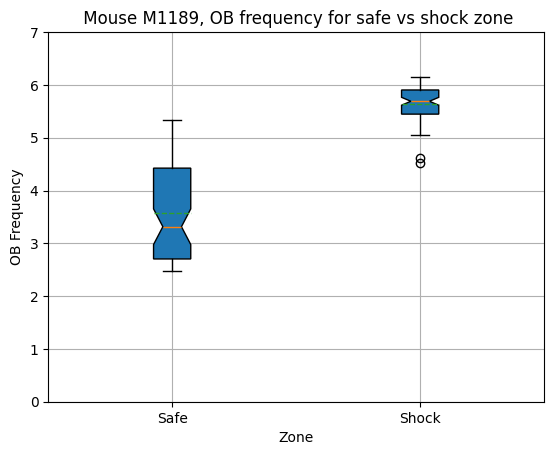

In [ ]:
# @title Figure 8/ Annex 2: Boxplot per mice

for mouse_id in mouse_ids:
    #Boxplot
    data_boxplot = [
        df_safe[mouse_id]['OB frequency'],  # Safe zone
        df_shock[mouse_id]['OB frequency']  # Shock zone
    ]

    total_data = df_filt[mouse_id]['OB frequency']

    # Calculate the proportion of safe data
    print(f"Mouse {mouse_id}:\nProportion of safe zone: {safe_proportion:.2%}")

    # Create the boxplot
    plt.boxplot(data_boxplot, labels=['Safe', 'Shock'], patch_artist=True, notch =True,  showmeans= True, meanline=True)
    plt.title(f' Mouse {mouse_id}, OB frequency for safe vs shock zone')
    plt.ylabel('OB Frequency')
    plt.ylim([0, 7])
    plt.xlabel('Zone')
    plt.grid()
    plt.show()


Mouse M688
Proportion dans le dataset = 31.725740848343985%
Proportion of safe zone: 89.38%
Proportion of shock zone: 10.62% 

Mouse M739
Proportion dans le dataset = 9.587449157466589%
Proportion of safe zone: 92.12%
Proportion of shock zone: 7.88% 

Mouse M777
Proportion dans le dataset = 9.296920395119116%
Proportion of safe zone: 58.13%
Proportion of shock zone: 41.88% 

Mouse M849
Proportion dans le dataset = 14.352120859965137%
Proportion of safe zone: 85.02%
Proportion of shock zone: 14.98% 

Mouse M893
Proportion dans le dataset = 20.685647879140035%
Proportion of safe zone: 88.20%
Proportion of shock zone: 11.80% 

Mouse M1171
Proportion dans le dataset = 5.287623474723998%
Proportion of safe zone: 76.92%
Proportion of shock zone: 23.08% 

Mouse M1189
Proportion dans le dataset = 9.06449738524114%
Proportion of safe zone: 41.03%
Proportion of shock zone: 58.97% 



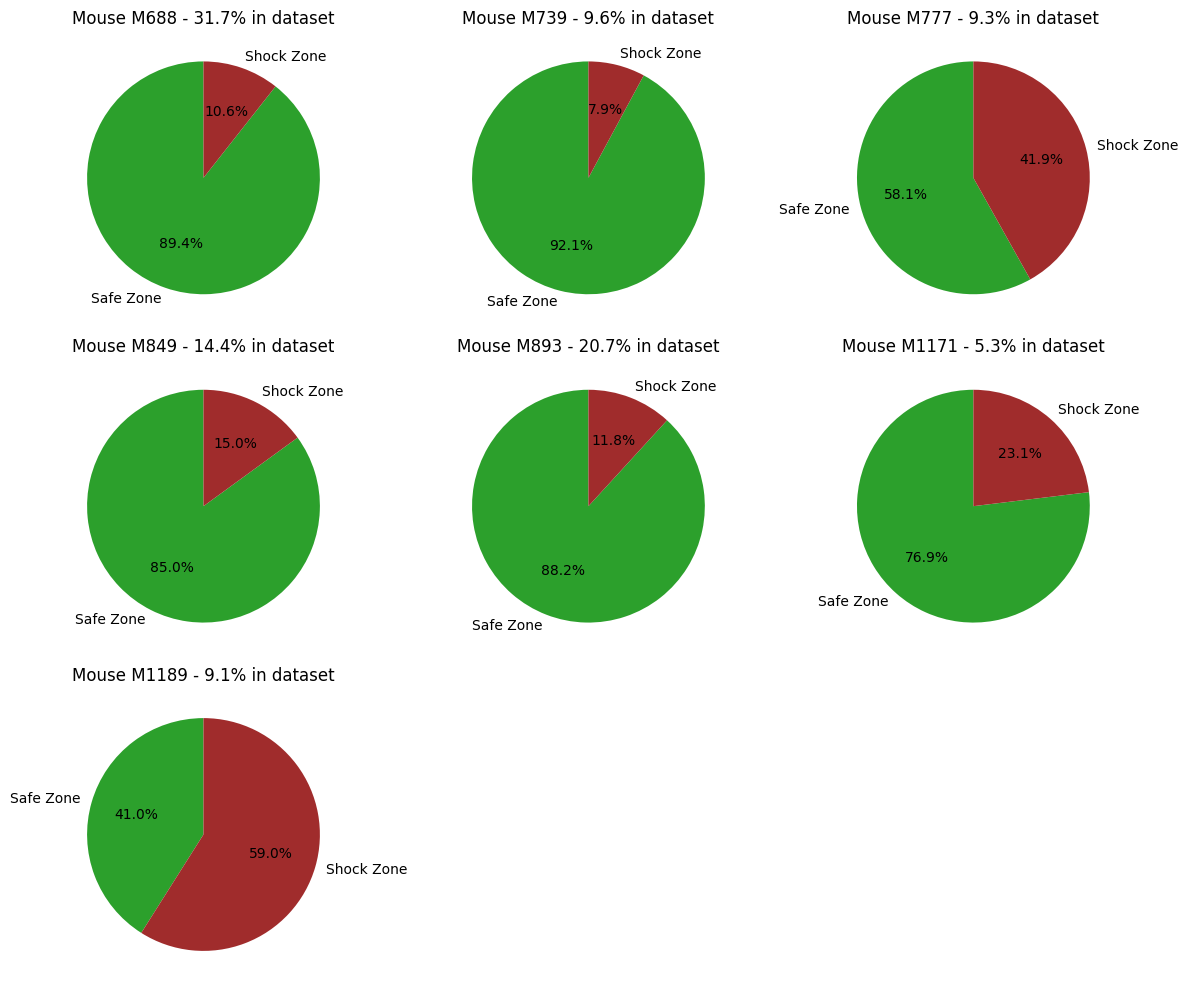

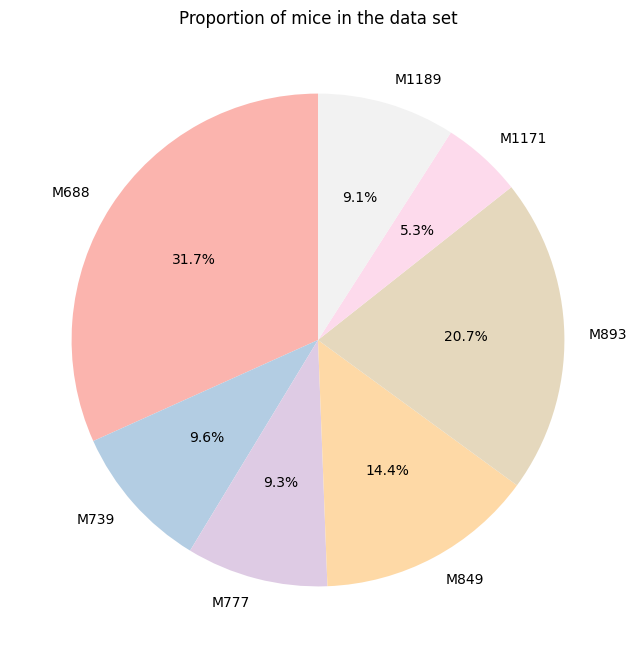

In [ ]:
# @title Figure 1 / Figure 20: Proportion

total_proportions = []
safe_proportions = []
shock_proportions = []

for mouse_id in mouse_ids:
    data_boxplot = [
        df_safe[mouse_id]['OB frequency'],  # Safe zone
        df_shock[mouse_id]['OB frequency']  # Shock zone
    ]

    total_data_mouse = df_filt[mouse_id]['OB frequency']

    proportion_souris= (len (combined_df[combined_df ['Mouse ID']==mouse_id])/ len (combined_df ))*100
    safe_proportion = len(df_safe[mouse_id]['OB frequency']) / len(total_data_mouse)
    shock_proportion = len(df_shock[mouse_id]['OB frequency']) / len(total_data_mouse)

    print (f"Mouse {mouse_id}")
    print (f"Proportion dans le dataset = {proportion_souris}%")
    print(f"Proportion of safe zone: {safe_proportion:.2%}")
    print(f"Proportion of shock zone: {shock_proportion:.2%} \n")

    total_proportions.append(proportion_souris)
    safe_proportions.append(safe_proportion)
    shock_proportions.append(shock_proportion)




# Pie chart

fig, axes = plt.subplots(3,3, figsize=(12, 10))
axes = axes.flatten()

for i, mouse_id in enumerate(mouse_ids):
    ax = axes[i]

    total = total_proportions[i]
    safe = safe_proportions[i]
    shock = shock_proportions[i]

    # Définir les données du pie chart
    labels = ['Safe Zone', 'Shock Zone']
    sizes = [safe, shock]
    colors = ['#2ca02c', '#a02c2c']

    # Créer le pie chart
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f"Mouse {mouse_id} - {total:.1f}% in dataset")

if len(mouse_ids) < len(axes):
    for j in range(len(mouse_ids), len(axes)):
        fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))

# Global pie chart
labels = mouse_ids
sizes = total_proportions
colors = plt.cm.Pastel1(np.linspace(0, 1, len(mouse_ids)))

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax.set_title("Proportion of mice in the data set")

plt.show()




In [ ]:
# @title Figure 8/Annex 2: Statistics per mouse

import scipy.stats as stats
from scipy.stats import wilcoxon

for mouse_id in mouse_ids:
    print (f"Mouse {mouse_id}")

    OB_shock= df_shock[mouse_id]['OB frequency']
    OB_safe= df_safe[mouse_id]['OB frequency']

    print (f"Mean shock zone {np.mean (OB_shock)}")
    print (f"Mean safe zone {np.mean (OB_safe)}")
    print (f"Standard deviation shock zone {np.std ( OB_shock)}")
    print (f"Standard deviatio safe zone {np.std ( OB_safe )}")

     # Length
    ## Bigger than 30 => ztest
    if len(OB_shock) >= 30 and len(OB_safe) >= 30:
        print (f"Samples bigger than 30, Shock : {len ( OB_shock)}, Safe : {len (OB_safe)}")
        # Use z-test for large sample sizes
        method = 'Z-test'
        print(f"Method: {method}")
        stat, p_value = sm.stats.ztest(OB_shock, OB_safe)


    ## Samples smaller than 30
    else :
        print (f"Samples smaller than 30, Shock : {len ( OB_shock)}, Safe : {len (OB_safe)}")

      # Normality testing : Shapiro - Wilk
        method = 'shapiro-wilk'
        stat1_shapi, p_value1_shapi = shapiro (OB_shock)
        stat2_shapi, p_value2_shapi = shapiro (OB_safe)
            # HO: the data was drawn from a normal distribution

        # Interpretation
        if p_value1_shapi < 0.05:
            print("Shock zone: We reject HO, data are  not drawn from a normal distribution.")
        else:
            print("Shock zone: We cannot reject the hypothesis that data come from a normal distribution.")

        if p_value2_shapi < 0.05:
            print("Safe zone: We reject HO, data are  not drawn from a normal distribution.")
        else:
            print("Safe zone: We cannot reject the hypothesis that data come from a normal distribution.")

        ## No normal distribution
        if p_value1_shapi < 0.05 or p_value2_shapi < 0.05:
            print ("No normal distribution")

            #Wilcoxon's test
            method = 'Wilcoxon Rank sum'
            #print (method)
            # Effectuer le test de Wilcoxon pour les deux échantillons
            stat, p_value = ranksums(OB_shock, OB_safe,
                        alternative='two-sided', nan_policy='omit')



        # Normal distribution proven
        else:
            print ("Normal distribution")
            #print("Normal distribution detected. Proceeding with parametric tests.")
            # Test for equal variances
            #print("Testing for equal variances (Levene's test)")
            stat_var, p_value_var = levene(OB_shock, OB_safe)

            if p_value_var < 0.05:
              print("Unequal variances detected. Using Welch's t-test.")
              method = "Welch's t-test"
              stat, p_value = ttest_ind(OB_shock, OB_safe, equal_var=False)
            else:
                print("Equal variances detected. Using standard t-test.")
                method = "t-test"
                stat, p_value = ttest_ind(OB_shock, OB_safe, equal_var=True)


    # Print
    print(f"{method} Test Results: Statistic = {stat}, p-value = {p_value}")

    # Interpreting
    if p_value < 0.05:
          print("We reject H0: Means are statistically different.\n")
    else:
          print("We cannot reject H0: Means are not statistically different.\n")

Mouse M688
Mean shock zone 3.6943668904917093
Mean safe zone 2.3431046299202736
Standard deviation shock zone 0.502046315846682
Standard deviatio safe zone 0.5858330049645869
Samples bigger than 30, Shock : 58, Safe : 488
Method: Z-test
Z-test Test Results: Statistic = 16.815543143936402, p-value = 1.8776377033913936e-63
We reject H0: Means are statistically different.

Mouse M739
Mean shock zone 3.2543524717673282
Mean safe zone 3.694919509668028
Standard deviation shock zone 0.6898470697770404
Standard deviatio safe zone 0.8212503781464545
Samples smaller than 30, Shock : 13, Safe : 152
Shock zone: We cannot reject the hypothesis that data come from a normal distribution.
Safe zone: We reject HO, data are  not drawn from a normal distribution.
No normal distribution
Wilcoxon Rank sum Test Results: Statistic = -1.7963855716122006, p-value = 0.07243321693856514
We cannot reject H0: Means are not statistically different.

Mouse M777
Mean shock zone 4.589725404914255
Mean safe zone 3.557

# Outliers

In [ ]:
# @title Function outliers

# Fonction to detect outliers
def detect_outliers(data, column):
     Q1 = data[column].quantile(0.25)
     Q3 = data[column].quantile(0.75)
     IQR = Q3 - Q1
     lower_bound = Q1 - (1.5 * IQR)
     upper_bound = Q3 + (1.5 * IQR)
     outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
     return outliers

In [ ]:
# @title Annex 6: Summary outliers
outlier_summary = pd.DataFrame(columns=['Mouse ID', 'Zone', 'Number', 'Percentage of Outliers'])
outliers_by_mouse = {}


# Iterate over all mice
for mouse_id in mouse_ids:
    # Extract Safe and Shock zone data for the mouse
    shock_zone_df = pd.DataFrame(df_shock[mouse_id]['OB frequency'])
    safe_zone_df = pd.DataFrame(df_safe[mouse_id]['OB frequency'])

    #print ( safe_zone_df)
    #print(safe_zone_df.columns)
    #print(shock_zone_df.columns)

    # Detect outliers in the Safe zone
    if not safe_zone_df.empty:  # Ensure safe_zone_df is not empty
        safe_outliers = detect_outliers(safe_zone_df, 'OB frequency')
        safe_outlier_percentage = len(safe_outliers) / len(safe_zone_df) * 100
    else:
        safe_outliers = pd.DataFrame()
        safe_outlier_percentage = 0

    # Detect outliers in the Shock zone
    if not shock_zone_df.empty:  # Ensure shock_zone_df is not empty
        shock_outliers = detect_outliers(pd.DataFrame(shock_zone_df), 'OB frequency')
        shock_outlier_percentage = len(shock_outliers) / len(shock_zone_df) * 100
    else:
        shock_outliers = pd.DataFrame()
        shock_outlier_percentage = 0

    # Store outliers for each mouse
    outliers_by_mouse[mouse_id] = {
        'Safe Outliers': safe_outliers,
        'Shock Outliers': shock_outliers
    }

    # Add results for Safe zone to the summary
    safe_summary = pd.DataFrame.from_records([{
        'Mouse ID': mouse_id,
        'Zone': 'Safe',
        'Number': len(safe_outliers),
        'Percentage of Outliers': safe_outlier_percentage
    }])
    outlier_summary = pd.concat([outlier_summary, safe_summary], ignore_index=True)

    # Add results for Shock zone to the summary
    shock_summary = pd.DataFrame.from_records([{
        'Mouse ID': mouse_id,
        'Zone': 'Shock',
        'Number': len(shock_outliers),
        'Percentage of Outliers': shock_outlier_percentage
    }])
    outlier_summary = pd.concat([outlier_summary, shock_summary], ignore_index=True)

# Display the summary of outliers
print(outlier_summary)


   Mouse ID   Zone Number  Percentage of Outliers
0      M688   Safe     11                2.254098
1      M688  Shock      0                0.000000
2      M739   Safe      0                0.000000
3      M739  Shock      0                0.000000
4      M777   Safe      2                2.150538
5      M777  Shock      0                0.000000
6      M849   Safe     18                8.571429
7      M849  Shock      0                0.000000
8      M893   Safe      0                0.000000
9      M893  Shock      0                0.000000
10    M1171   Safe      0                0.000000
11    M1171  Shock      0                0.000000
12    M1189   Safe      0                0.000000
13    M1189  Shock      2                2.173913


<ipython-input-25-e6dbfdba6f2e>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outlier_summary = pd.concat([outlier_summary, safe_summary], ignore_index=True)


#   Correlation

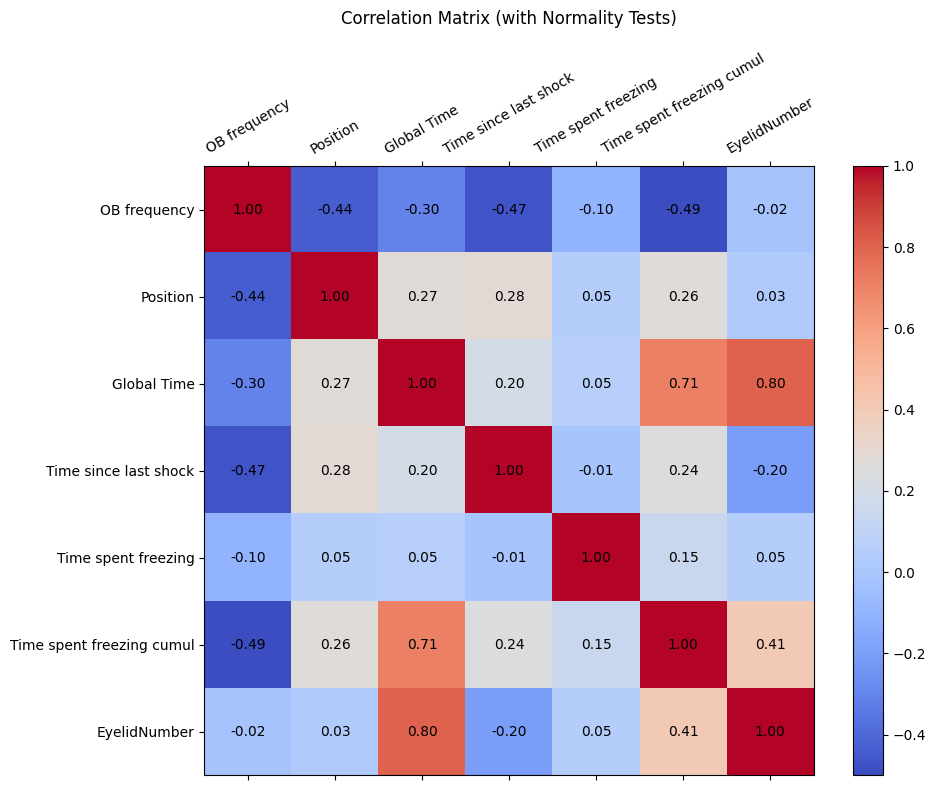

In [ ]:
# @title Figure 11/ Annex 3: Correlation all mice

columns_combined = combined_df.columns.tolist()

#print (columns_combined )
columns_combined.remove ('Mouse ID' )
 #print (columns_combined )

#1. Test normality
normality_results = {}
for col in columns_combined:
    stat, p_value = stats.shapiro(combined_df[col])
    normality_results[col] = {'Normality': p_value > 0.05, 'p_value': p_value}


#2. Correlation
n_columns = len(columns_combined)
corr_matrix = np.zeros((n_columns, n_columns))

for i, col1 in enumerate(columns_combined):
    for j, col2 in enumerate(columns_combined):
        if i <= j:
            X = combined_df[col1]
            Y = combined_df[col2]

            # Chooosing the correlation test depending on normality
            if normality_results[col1]['Normality'] and normality_results[col2]['Normality']:
                corr, p_value = stats.pearsonr(X, Y)
                test_type = 'Pearson'
                correlation_results = [corr,p_value,test_type]
            else:
                corr, p_value = stats.spearmanr(X, Y)
                test_type = 'Spearman'
                correlation_results = [corr,p_value,test_type]

            # Stocker les résultats
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr


#3. Affichage de la heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Heatmap des corrélations
im = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-0.5)
plt.colorbar(im)

for i in range(n_columns):
    for j in range(n_columns):
        c = "{:.2f}".format(corr_matrix[i, j])
        ax.text(j, i, c, va='center', ha='center', color='black')

# Ajouter les étiquettes des axes
ax.set_xticks(range(n_columns))
ax.set_yticks(range(n_columns))
ax.set_xticklabels(columns_combined, rotation=30, ha='center')
ax.set_yticklabels(columns_combined, rotation=0)

# Titre de la figure
ax.set_title("Correlation Matrix (with Normality Tests)", pad=20)

plt.tight_layout()
plt.show()


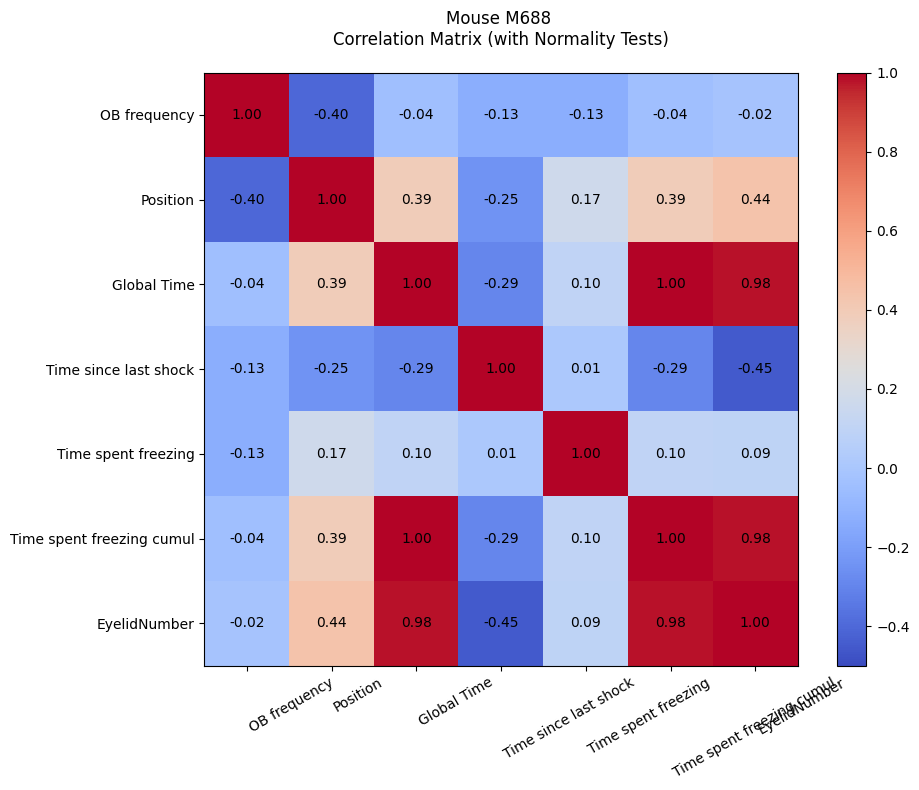

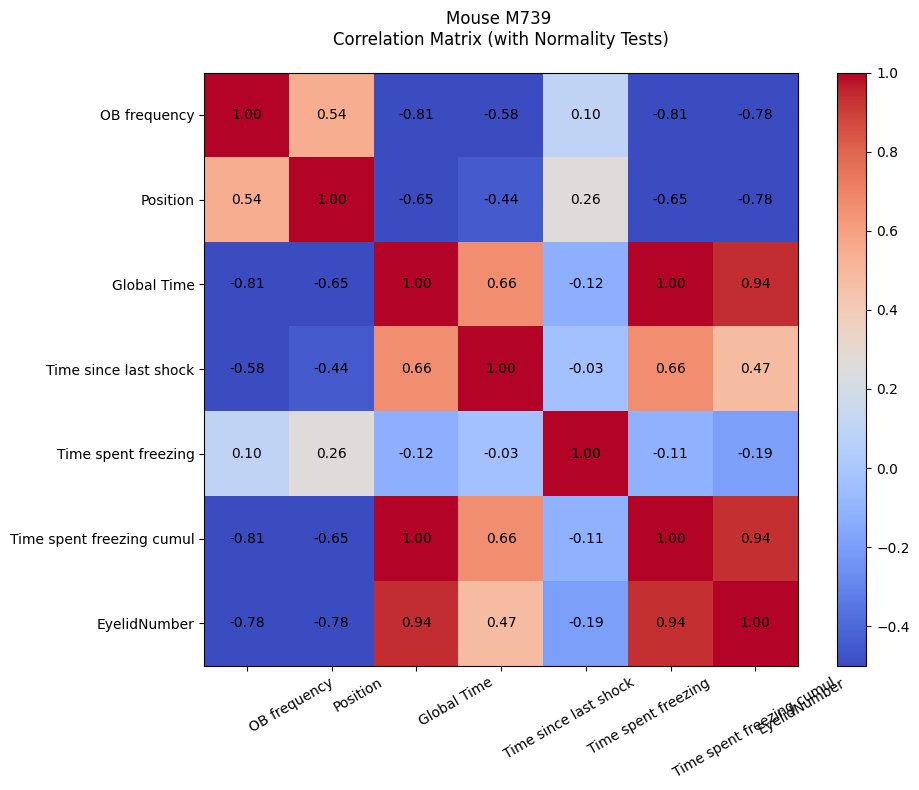

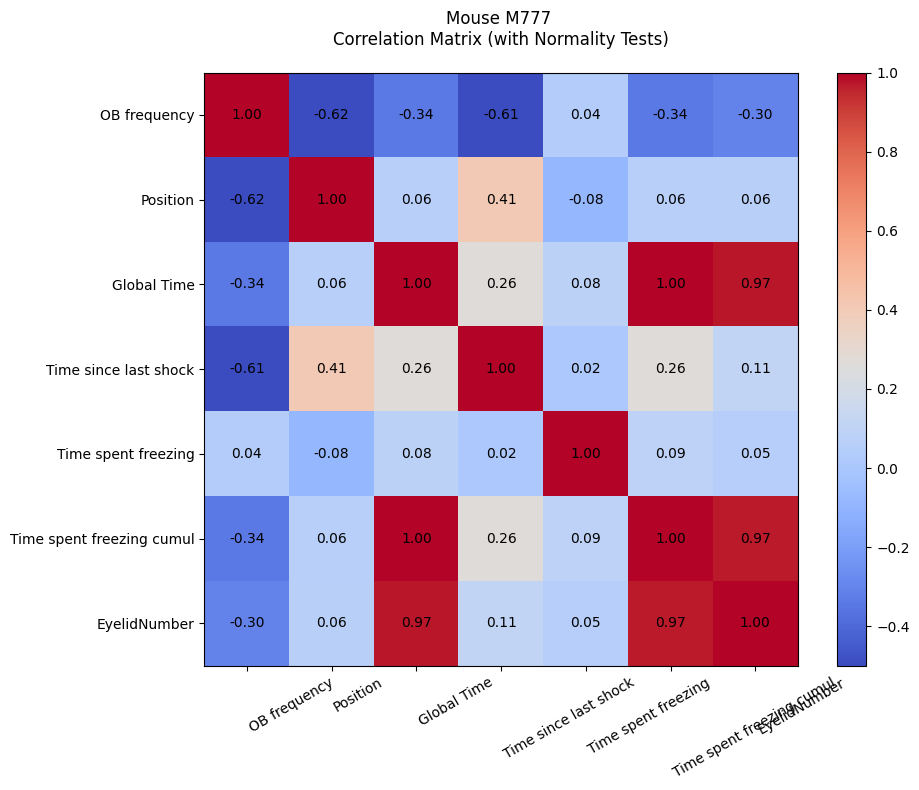

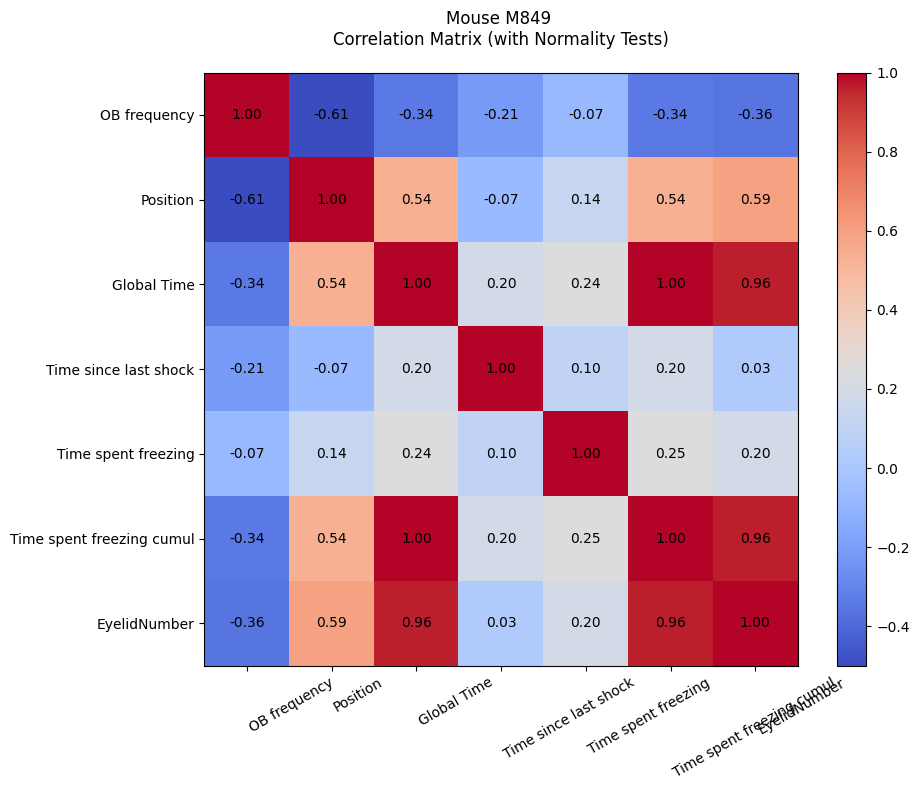

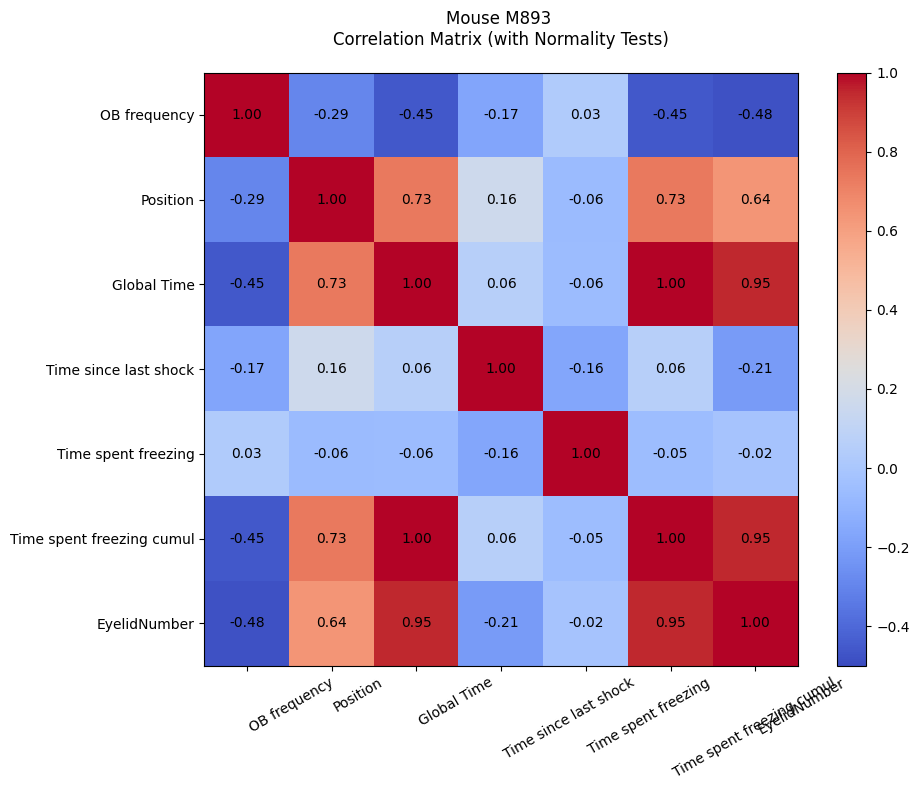

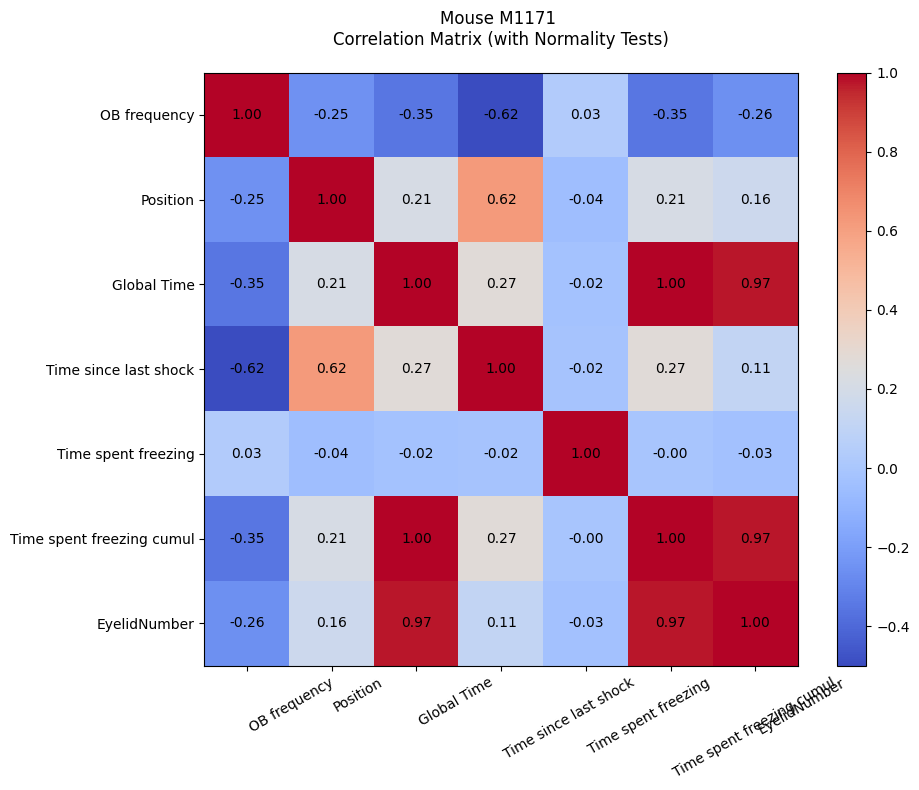

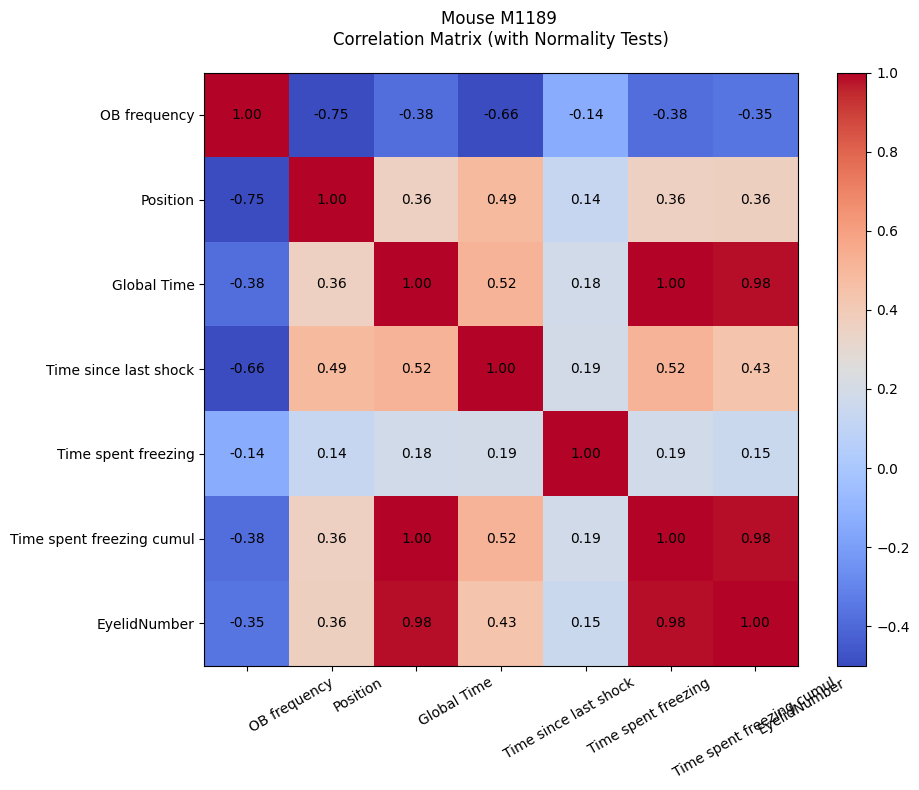

In [ ]:
# @title Annex 3: Correlation per mice
# Ensure data_normality is defined before correlation calculations
columns=columns_combined
data_normality = {}
for mouse_id in mouse_ids:
    data_normality[mouse_id] = {}
    #df_mouse = pd.DataFrame(df_filt[mouse_id]) if isinstance(df_filt[mouse_id], pd.Series) else df_filt[mouse_id]
    df_mouse = df_filt[mouse_id]
    #df_mouse = df_filt[df_filt['Mouse ID'] == mouse_id]
    #print ( df_mouse)
    #print ( df_mouse[columns])
    for col in columns:
        stat, p_value = stats.shapiro(df_filt[mouse_id][col])
        data_normality[mouse_id][col] = {'Normality': p_value > 0.05, 'p_value': p_value}

# Iterate over each mouse
for mouse_id in mouse_ids:
    corr_matrice = np.zeros((len (columns),len (columns)))

    # Compute correlations
    for i in range(len (columns)):
        for j in range(len (columns)):
            print
            corr_matrice[i, j] = correlation(df_filt, mouse_id, columns[i], columns[j])[0]

    fig, ax = plt.subplots(figsize=(10, 8))

    # Heatmap with a fixed scale (0 to 1 for better contrast)
    im = ax.matshow(corr_matrice, cmap='coolwarm', vmin=-0.5)
    plt.colorbar(im)

    # Display correlation values
    for i in range(7):
        for j in range(7):
            c = "{:.2f}".format(corr_matrice[j, i])
            ax.text(i, j, str(c), va='center', ha='center', color='black')

    # Axis labels
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(range(len(columns_combined)))
    ax.set_yticks(range(len(columns_combined)))
    ax.set_xticklabels(columns_combined, rotation=30, ha='left')
    ax.set_yticklabels(columns_combined, rotation=0)

    # Title
    ax.set_title(f"Mouse {mouse_id} \nCorrelation Matrix (with Normality Tests)", pad=20)

    plt.tight_layout()
    plt.show()


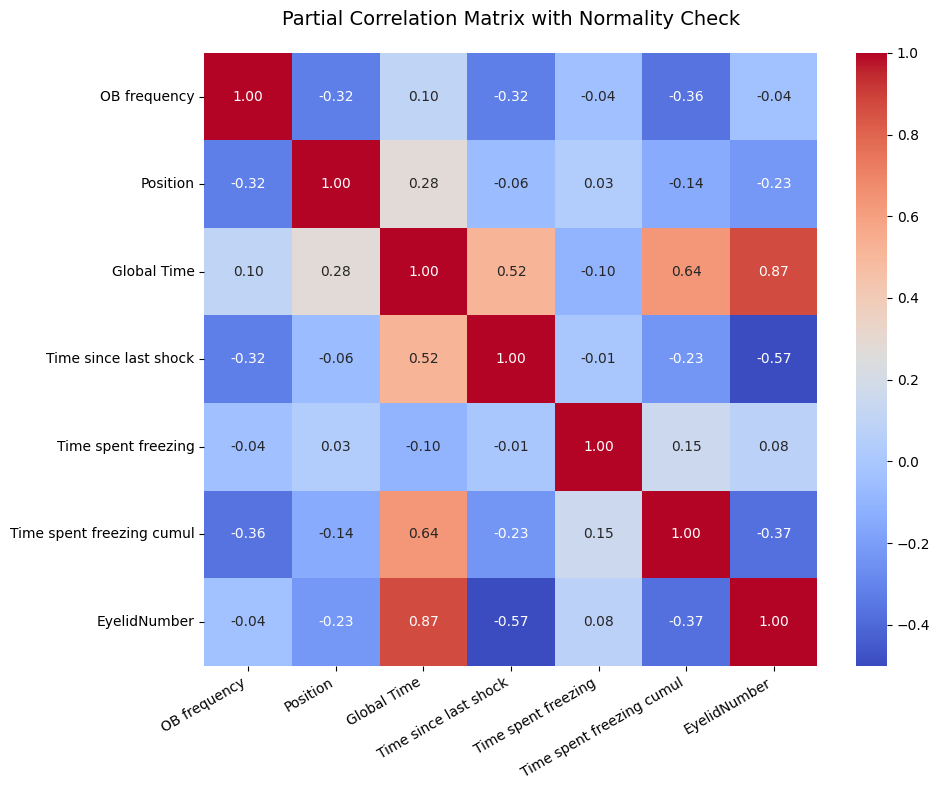

In [ ]:
#  @title Figure 12: Partial correlation all mice

target_var = "OB frequency"
columns = ['OB frequency' , 'Linear Position', 'Global Time', 'Time since last shock', 'Time spent freezing', 'Time spent freezing cumul', 'EyelidNumber']

all_variables= ['OB frequency' ,'Position', 'Global Time', 'Time since last shock', 'Time spent freezing', 'Time spent freezing cumul', 'EyelidNumber']

combined_df_data= combined_df.drop (columns= ["Mouse ID"])

# 1. Tester normality
normality_results = {}
for col in all_variables:
    _, p_value = stats.shapiro(combined_df[col])
    normality_results[col] = p_value > 0.05
    #print ( normality_results)
n_columns= len ( all_variables )


# 2. Calculer la corrélation partielle

partial_corr_matrix = np.zeros((n_columns, n_columns))

# Calcul des corrélations partielles
for i, col1 in enumerate(all_variables):
    for j, col2 in enumerate(all_variables):
        if i < j:  # Calculer uniquement la moitié supérieure

            if normality_results[col1] and normality_results[col2]:
                corr_method = 'pearson'
            else:  # At least one is not normal
                corr_method = 'spearman'

            covariates = [col for col in all_variables if col != col1 and col != col2]

            # Utiliser pairwise_corr avec covariables
            pcorr = pg.pairwise_corr(data=combined_df_data,
                                    columns=[col1, col2],
                                    covar=covariates,
                                    method=corr_method)

            # Remplir la matrice avec la valeur de corrélation partielle (r)
            partial_corr_matrix[i, j] = pcorr["r"].iloc[0]  # Première ligne du résultat
            partial_corr_matrix[j, i] = pcorr["r"].iloc[0]  # Symétrie de la matrice

        if i== j :
            partial_corr_matrix[i, j] = 1
            partial_corr_matrix[j, i] = 1

# 3. Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(partial_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=all_variables, yticklabels=all_variables, square=True, cbar=True, ax=ax,vmin= -0.5)

ax.set_title("Partial Correlation Matrix with Normality Check", fontsize=14, pad=20)
plt.xticks(rotation=30, ha= 'right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

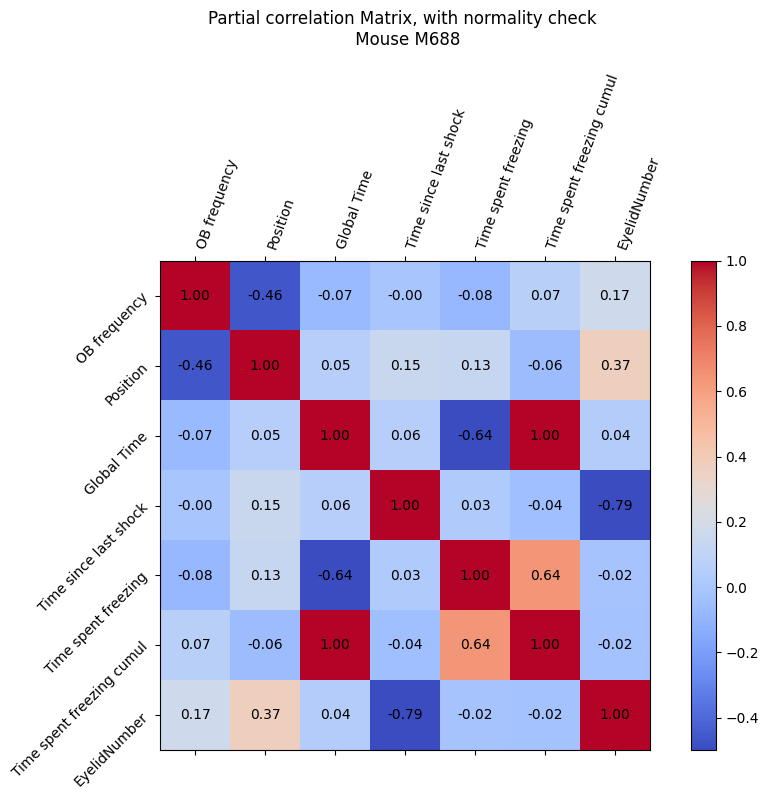

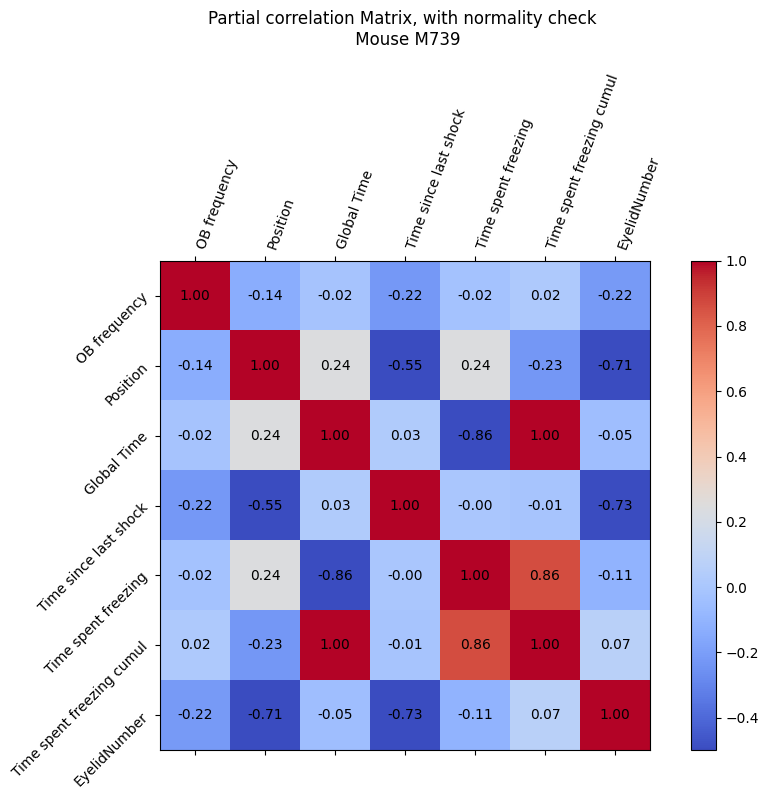

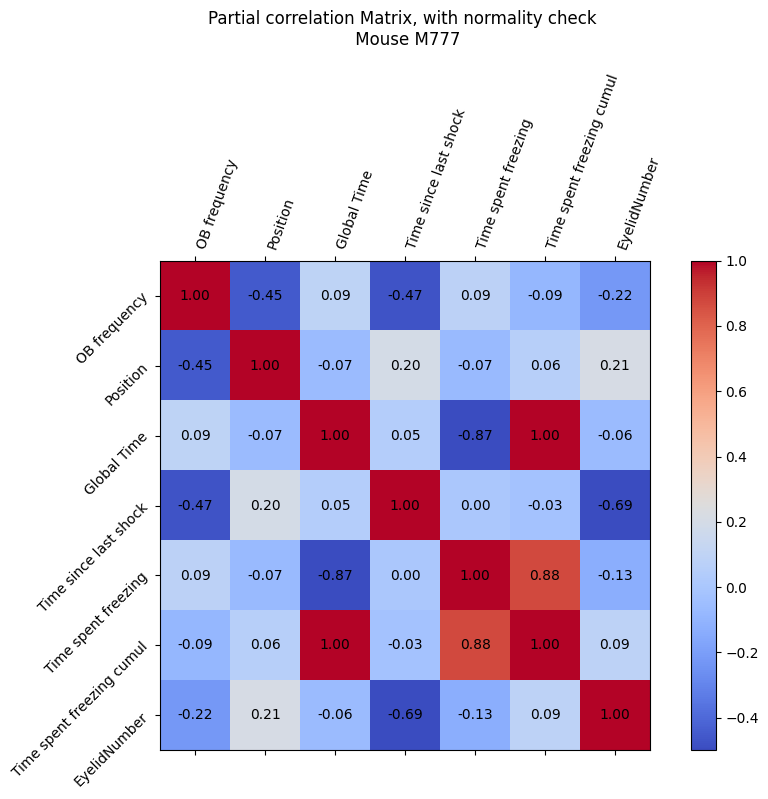

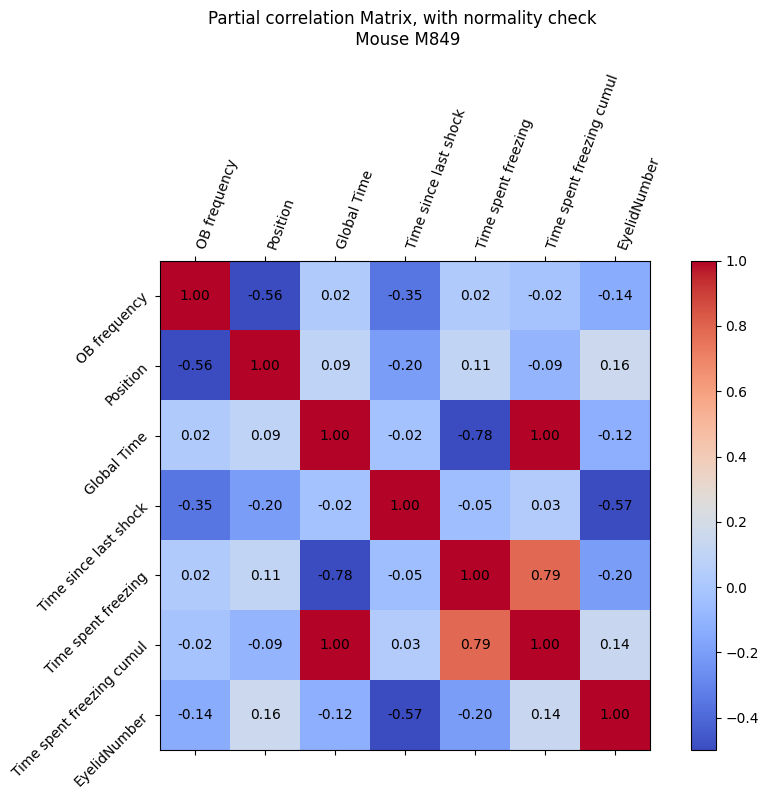

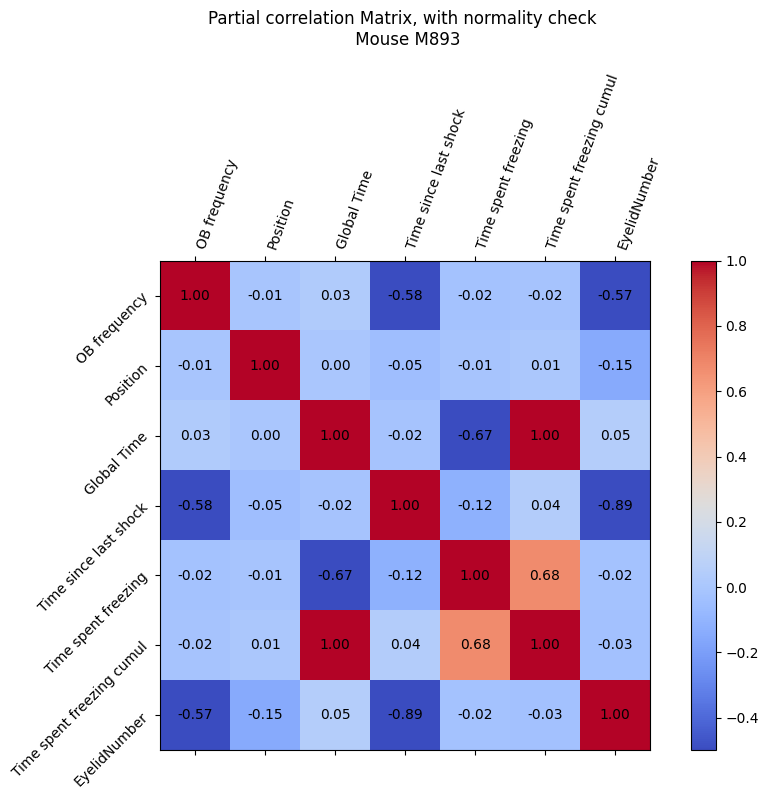

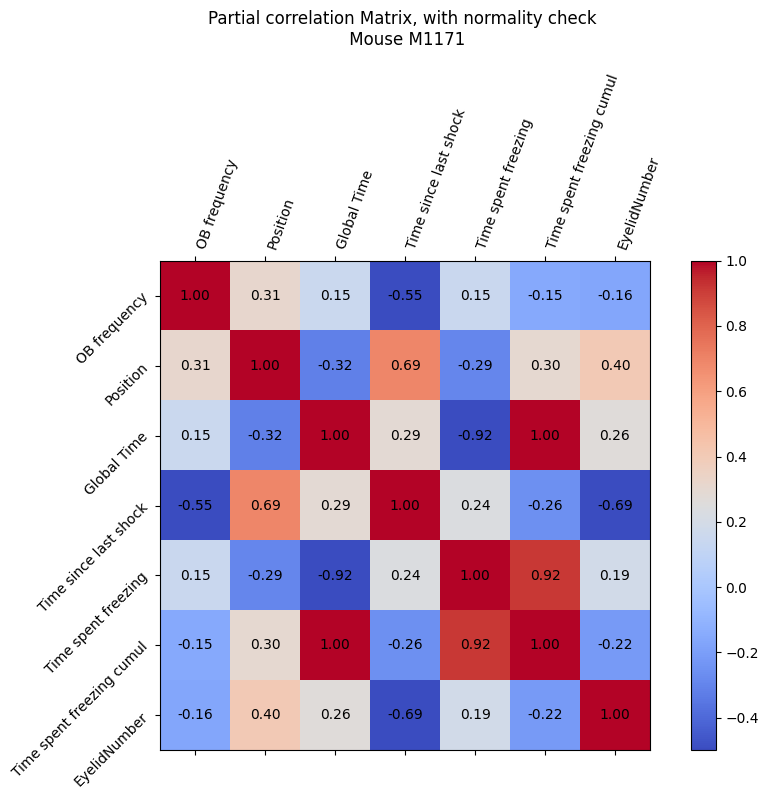

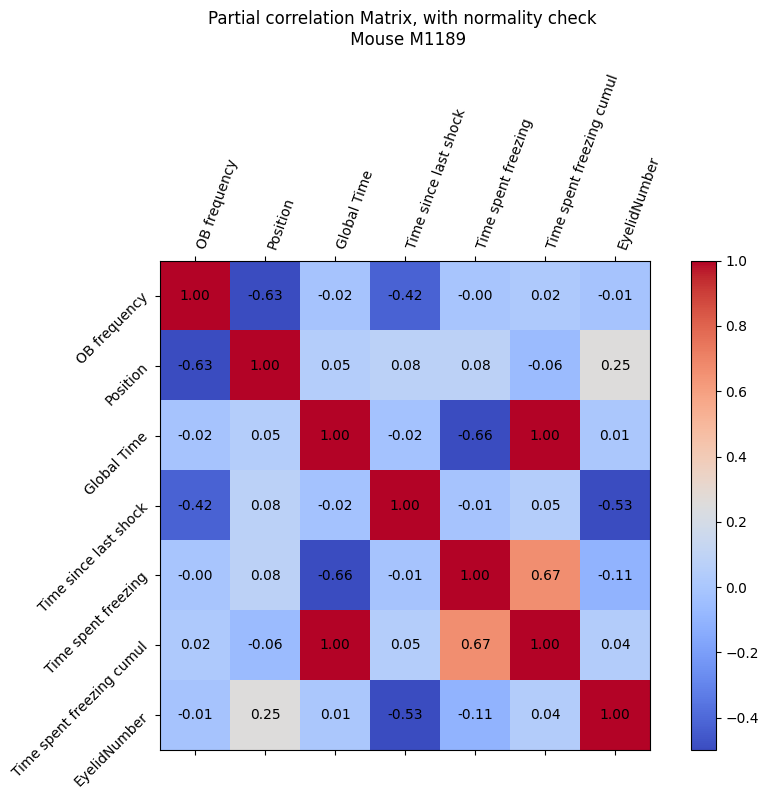

In [ ]:
# @title Annex 4: Global partial correlation matrix per mouse


target_var = "OB frequency"
columns = ['OB frequency' , 'Position', 'Global Time', 'Time since last shock', 'Time spent freezing', 'Time spent freezing cumul', 'EyelidNumber']
#all_variables= []



for mouse_id in mouse_ids:
    mouse_data =combined_df[ combined_df ['Mouse ID']==mouse_id ]
    #print (mouse_data)
    n_columns= len ( columns )


    #1. Normality
    normality_results = {}
    for col in columns:
        _, p_value = stats.shapiro(mouse_data[col])
        normality_results[col] = p_value > 0.05
        #print ( normality_results)


    # Calculer la corrélation partielle
    partial_corr_matrix = np.zeros((n_columns, n_columns))

    # Calcul des corrélations partielles
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i < j:  # Symetrical matrix

                if normality_results[col1] and normality_results[col2]:
                    corr_method = 'pearson'
                else:  # At least one is not normal
                    corr_method = 'spearman'

                covariates = [col for col in all_variables if col != col1 and col != col2]

                # Utiliser pairwise_corr avec covariables
                #print(covariates)
                pcorr = pg.pairwise_corr(data=mouse_data,
                                        columns=[col1, col2],
                                        covar=covariates,
                                        method=corr_method)

                # Remplir la matrice avec la valeur de corrélation partielle (r)
                partial_corr_matrix[i, j] = pcorr["r"].iloc[0]
                partial_corr_matrix[j, i] = pcorr["r"].iloc[0]  # Symetrical

            if i== j :
                partial_corr_matrix[i, j] = 1
                partial_corr_matrix[j, i] = 1

    # Création de la heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.matshow(partial_corr_matrix, cmap='coolwarm', vmin=-0.5)
    plt.colorbar(im)
    for i in range(n_columns):
        for j in range(n_columns):
            c = "{:.2f}".format(partial_corr_matrix[i, j])
            ax.text(j, i, c, va='center', ha='center', color='black')

    # Add ticks
    ax.set_xticks(range(n_columns))
    ax.set_yticks(range(n_columns))
    ax.set_xticklabels(columns, rotation=70, ha='left')
    ax.set_yticklabels(columns, rotation= 45)



    # Titre de la figure
    ax.set_title(f"Partial correlation Matrix, with normality check \n Mouse {mouse_id}", pad=20)

    plt.tight_layout()
    plt.show()


<ipython-input-30-067984036464>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  partial_corr_results = pd.concat([partial_corr_results, pd.DataFrame([row_results])], ignore_index=True)


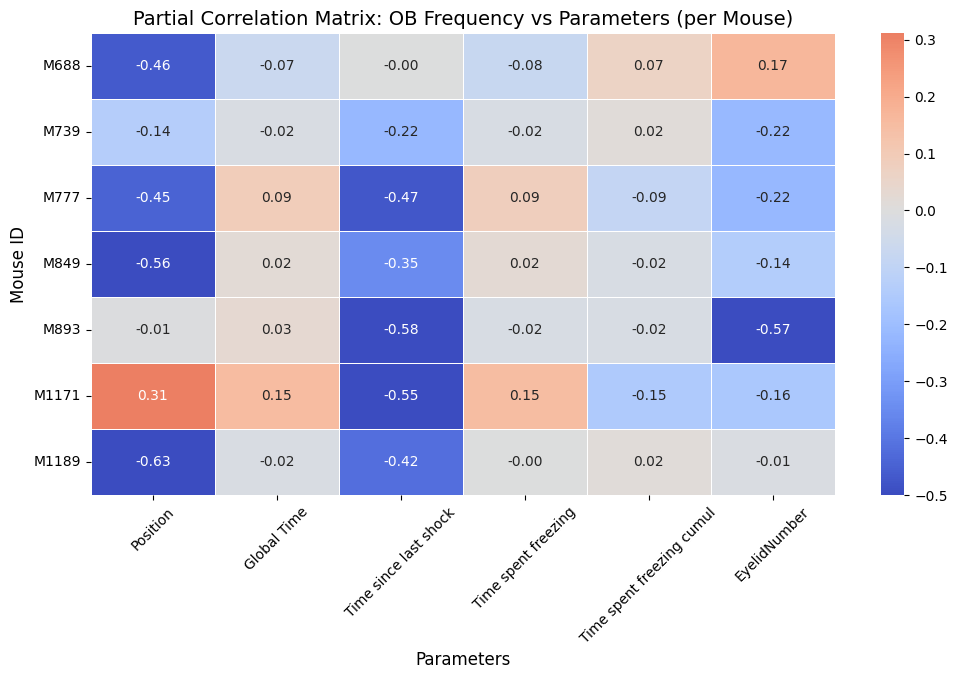

In [ ]:
# @title Figure 21: Partial correlation for each between OB Frequncy and all parameters
# Define variables
target_var = "OB frequency"
columns = ['Position', 'Global Time', 'Time since last shock',
           'Time spent freezing', 'Time spent freezing cumul', 'EyelidNumber']
all_variables = [target_var] + columns

# Create an empty DataFrame to store results
partial_corr_results = pd.DataFrame(columns=["Mouse ID"] + columns)

# Loop through each mouse
for mouse_id in mouse_ids:
    mouse_data = combined_df[combined_df['Mouse ID'] == mouse_id]


    # Normality check
    normality_results = {}
    for col in all_variables:
        _, p_value = stats.shapiro(mouse_data[col])
        normality_results[col] = p_value > 0.05  # True if normal, False otherwise

    # Compute partial correlations
    row_results = {"Mouse ID": mouse_id}
    for col2 in columns:
        if normality_results[target_var] and normality_results[col2]:
            corr_method = 'pearson'
        else:
            corr_method = 'spearman'

        # Covariates: all variables except target_var and col2
        covariates = [col for col in all_variables if col not in [target_var, col2]]

        # Compute partial correlation
        pcorr = pg.pairwise_corr(data=mouse_data,
                                 columns=[target_var, col2],
                                 covar=covariates,
                                 method=corr_method)

        row_results[col2] = pcorr["r"].iloc[0]  # Extract partial correlation coefficient

    # Append results to the DataFrame
    partial_corr_results = pd.concat([partial_corr_results, pd.DataFrame([row_results])], ignore_index=True)

# Remove "Mouse ID" column for heatmap
heatmap_data = partial_corr_results.set_index("Mouse ID")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f", vmin=-0.5)

# Labels and title
plt.title("Partial Correlation Matrix: OB Frequency vs Parameters (per Mouse)", fontsize=14)
plt.xlabel("Parameters", fontsize=12)
plt.ylabel("Mouse ID", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()
